# 0.0. IMPORTS

In [1]:
import math
import secrets
import datetime
import inflection
import numpy               as np
import pandas              as pd
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec


from boruta                 import BorutaPy
from tabulate               import tabulate
from IPython.display        import Image
from IPython.core.display   import HTML
from dython.nominal         import associations
from sklearn.ensemble       import RandomForestRegressor
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'csv/train.csv', low_memory=False)
df_store_raw = pd.read_csv( 'csv/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on='Store')

# 1.0. STEP 01- DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print(f'Number Of Rows: {(df1.shape[0])}')
print(f'Number Of Cols: {(df1.shape[1])}')

Number Of Rows: 1017209
Number Of Cols: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. NA Check

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FIllout NA

In [10]:
# competition_distance
# ASSUMPTION: 
# NA significa não ter concorrencia.
# Vou atribuir um valor maior que o maximo dessa coluna.
# Maximo da Coluna: 75860.0 > Vou atribuir o valor 200000.0 para os NA
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)


# competition_open_since_month
# Visando o Feature Engineering:
# ASSUMPTION:
# Vou retirar o mes da coluna (date), assumindo que o competidor foi aberto no mes do registro (Teste para o Primeiro Ciclo CRISP-DS)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
# Visando o Feature Engineering:
# ASSUMPTION:
# Vou retirar o ano da coluna (date), assumindo que o competidor foi aberto no ano do registro (Teste para o Primeiro Ciclo CRISP-DS)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
# NA significa que a loja decidiu não participar / extender a promoção
# ASSUMPTION:
# Vou atribuir ao NA a semana da data que está na mesma linha
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
# ASSUMPTION:
# Vou atribuir ao NA o ano da data que está na mesma linha
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map =  {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'] = df1['promo_interval'].fillna(0)

# month_map (create)
df1['month_map'] = df1['date'].dt.month.map(month_map)

# is_promo (create)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0 , axis=1)

## 1.6. Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

### 1.7.1 Numerical Statistical

In [12]:
num_attributes = df1.select_dtypes( include= ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'])

In [13]:
# Central Tendency - mean, median / Dispersion - std, min, max, range, skew, kurtosis
m = num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

### 1.7.2 Categorical Statistical

In [14]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

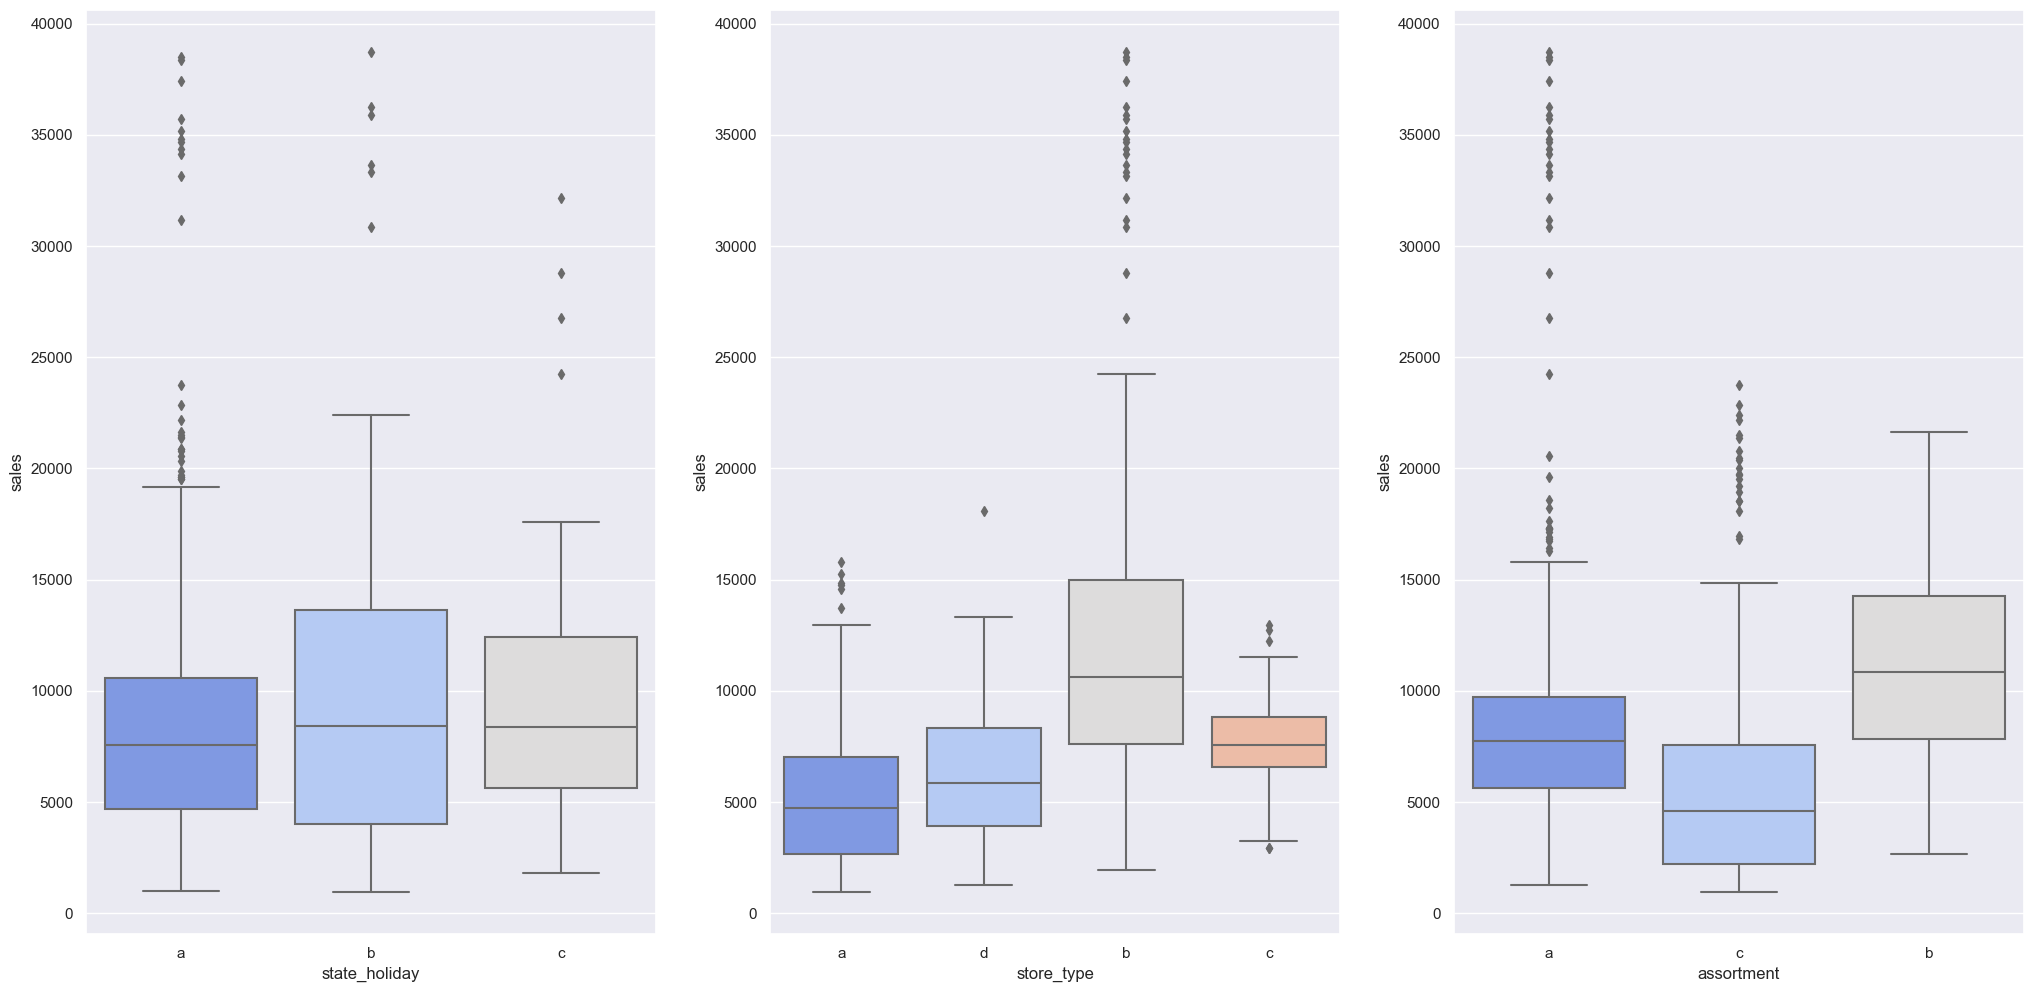

In [15]:

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(
    data= aux1, 
    x='state_holiday', y= 'sales', 
    palette= sns.color_palette('coolwarm', n_colors=5),
    boxprops=dict(alpha=1)
)

plt.subplot(1, 3, 2)
sns.boxplot(
    data= aux1, 
    x='store_type', y= 'sales', 
    palette= sns.color_palette('coolwarm', n_colors=5),
    boxprops=dict(alpha=1)
)

plt.subplot(1, 3, 3)
sns.boxplot(
        data= aux1, 
        x='assortment', y= 'sales',
        palette= sns.color_palette('coolwarm', n_colors=5),
        boxprops=dict(alpha=1)
);


# 2.0. STEP 02 - FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

## 2.1 MIND MAP HYPOTHESIS

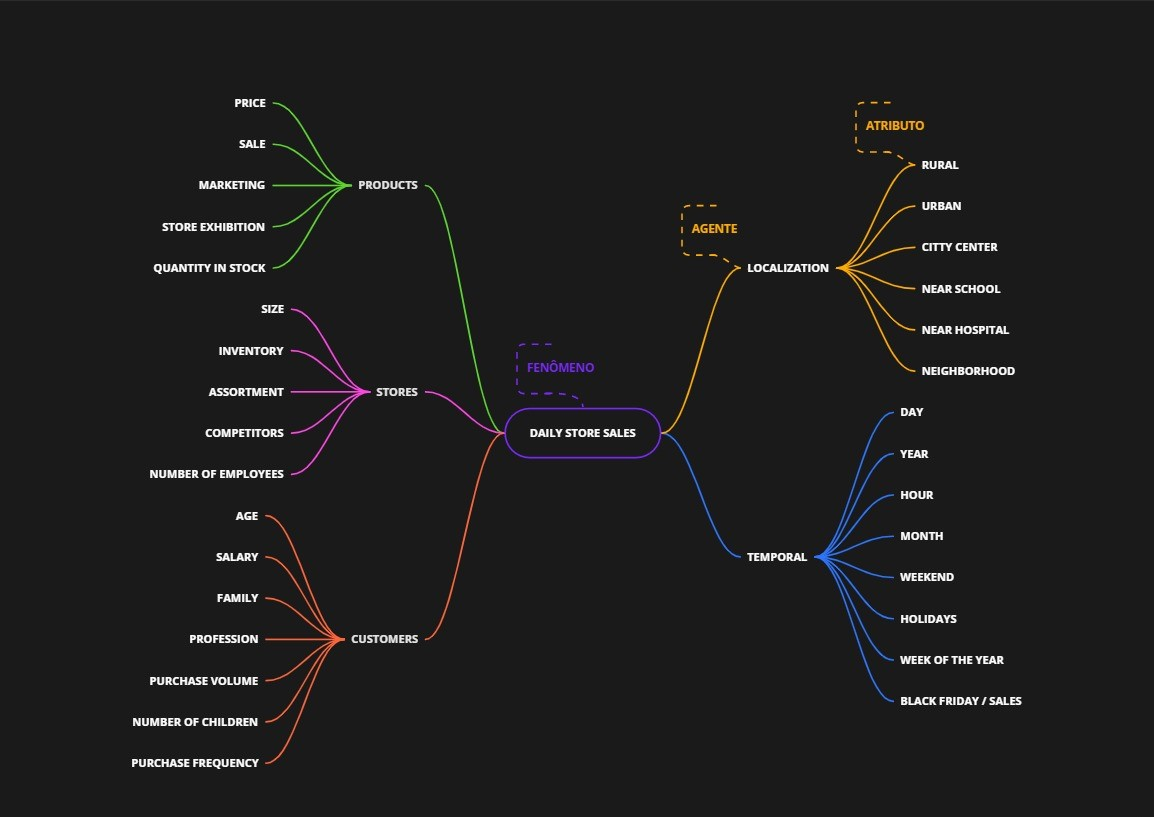

In [17]:
Image( 'img/MindMap.jpg')

## 2.2 CREATE HYPOTHESIS

### 2.2.1 STORE HYPOTHESIS

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.


### 2.2.2 PRODUCT HYPOTHESIS

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais


### 2.2.3 TIME HYPOTHESIS

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. FINAL LIST - HYPOTHESIS

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.4. FEATURE ENGINEERING

In [18]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day= 1), axis=1)

# competition time month
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# promo time week
df2['promo_time_week']= ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')

# assortment - a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday - a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. STEP 03 - VARIABLE FILTERING

In [19]:
df3 = df2.copy()

## 3.1. ROW FILTERING

In [20]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. COLUMN SELECTION

In [21]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [22]:
df4 = df3.copy()

## 4.1. UNIVARIATE ANALYSIS

### 4.1.1 RESPONSE VARIABLE

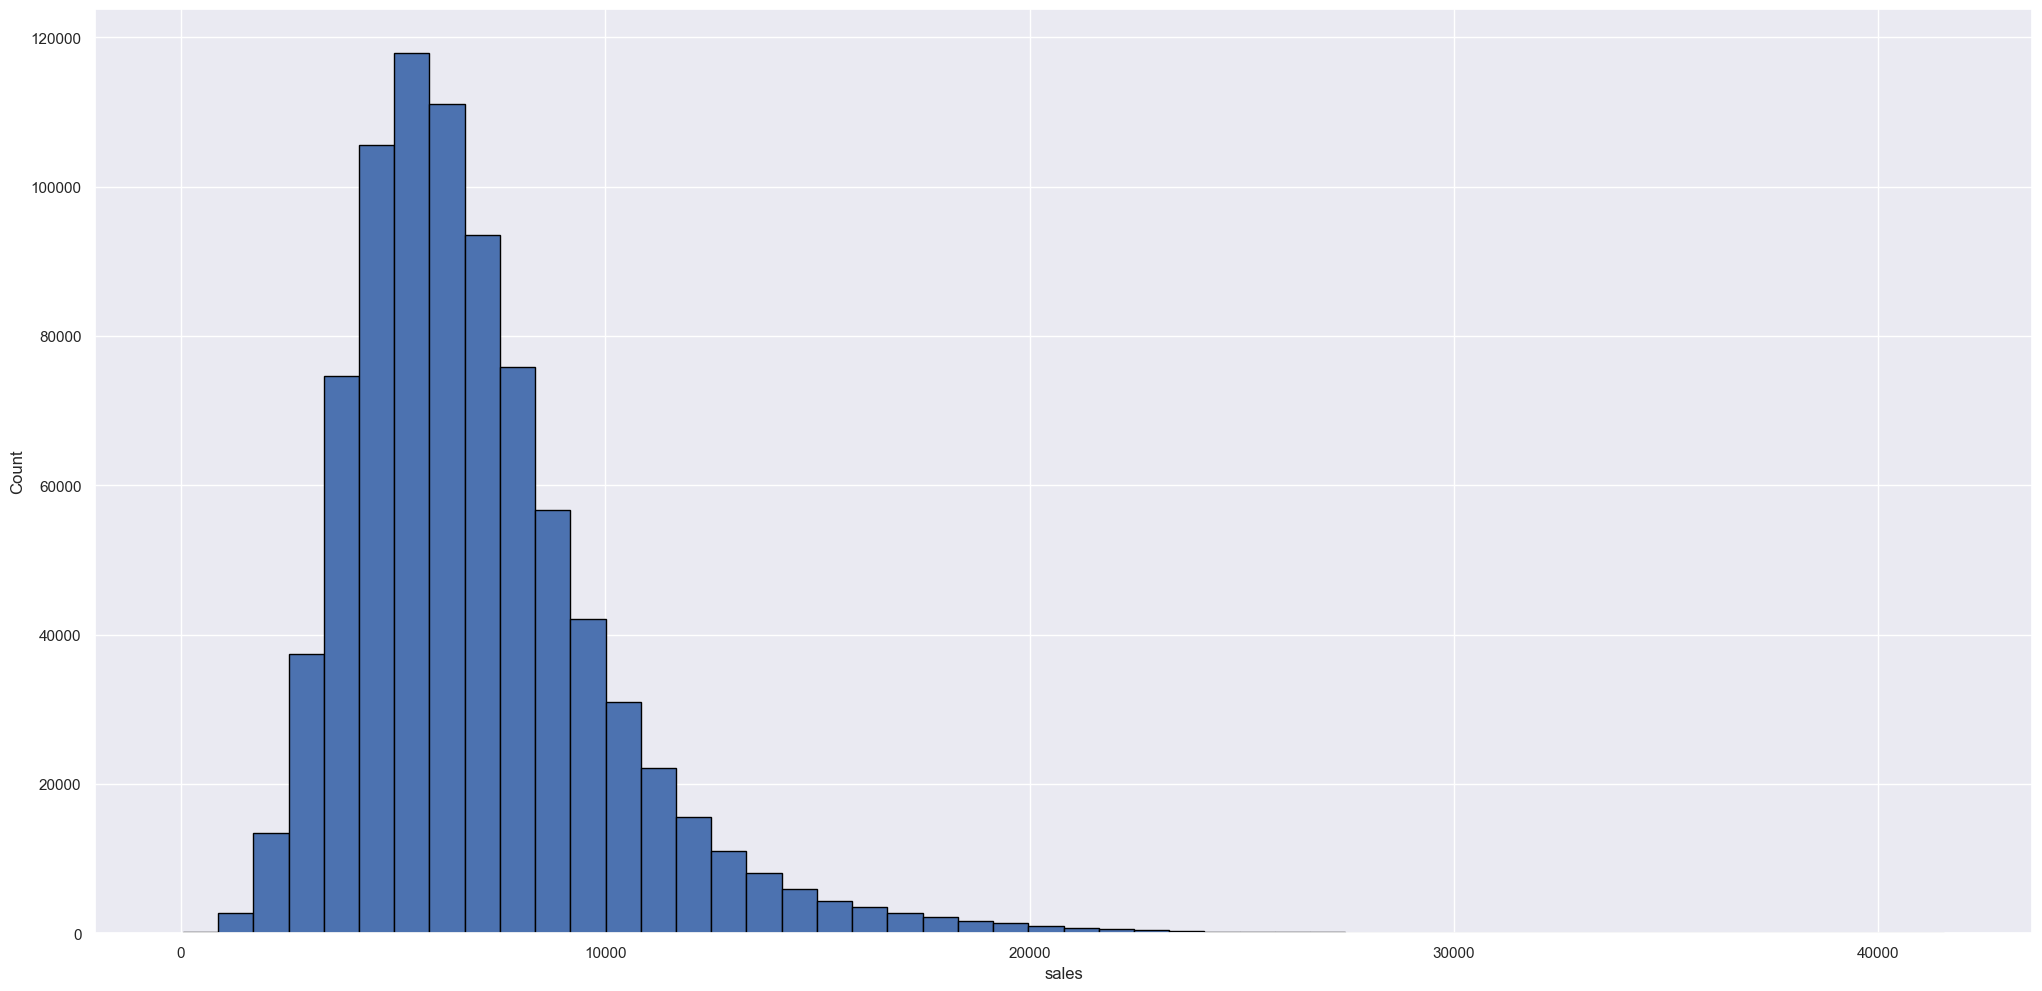

In [23]:
sns.histplot(df4['sales'], bins= 50, palette= 'coolwarm', alpha=1.0, edgecolor= 'black');


### 4.1.2 NUMERICAL VARIABLE

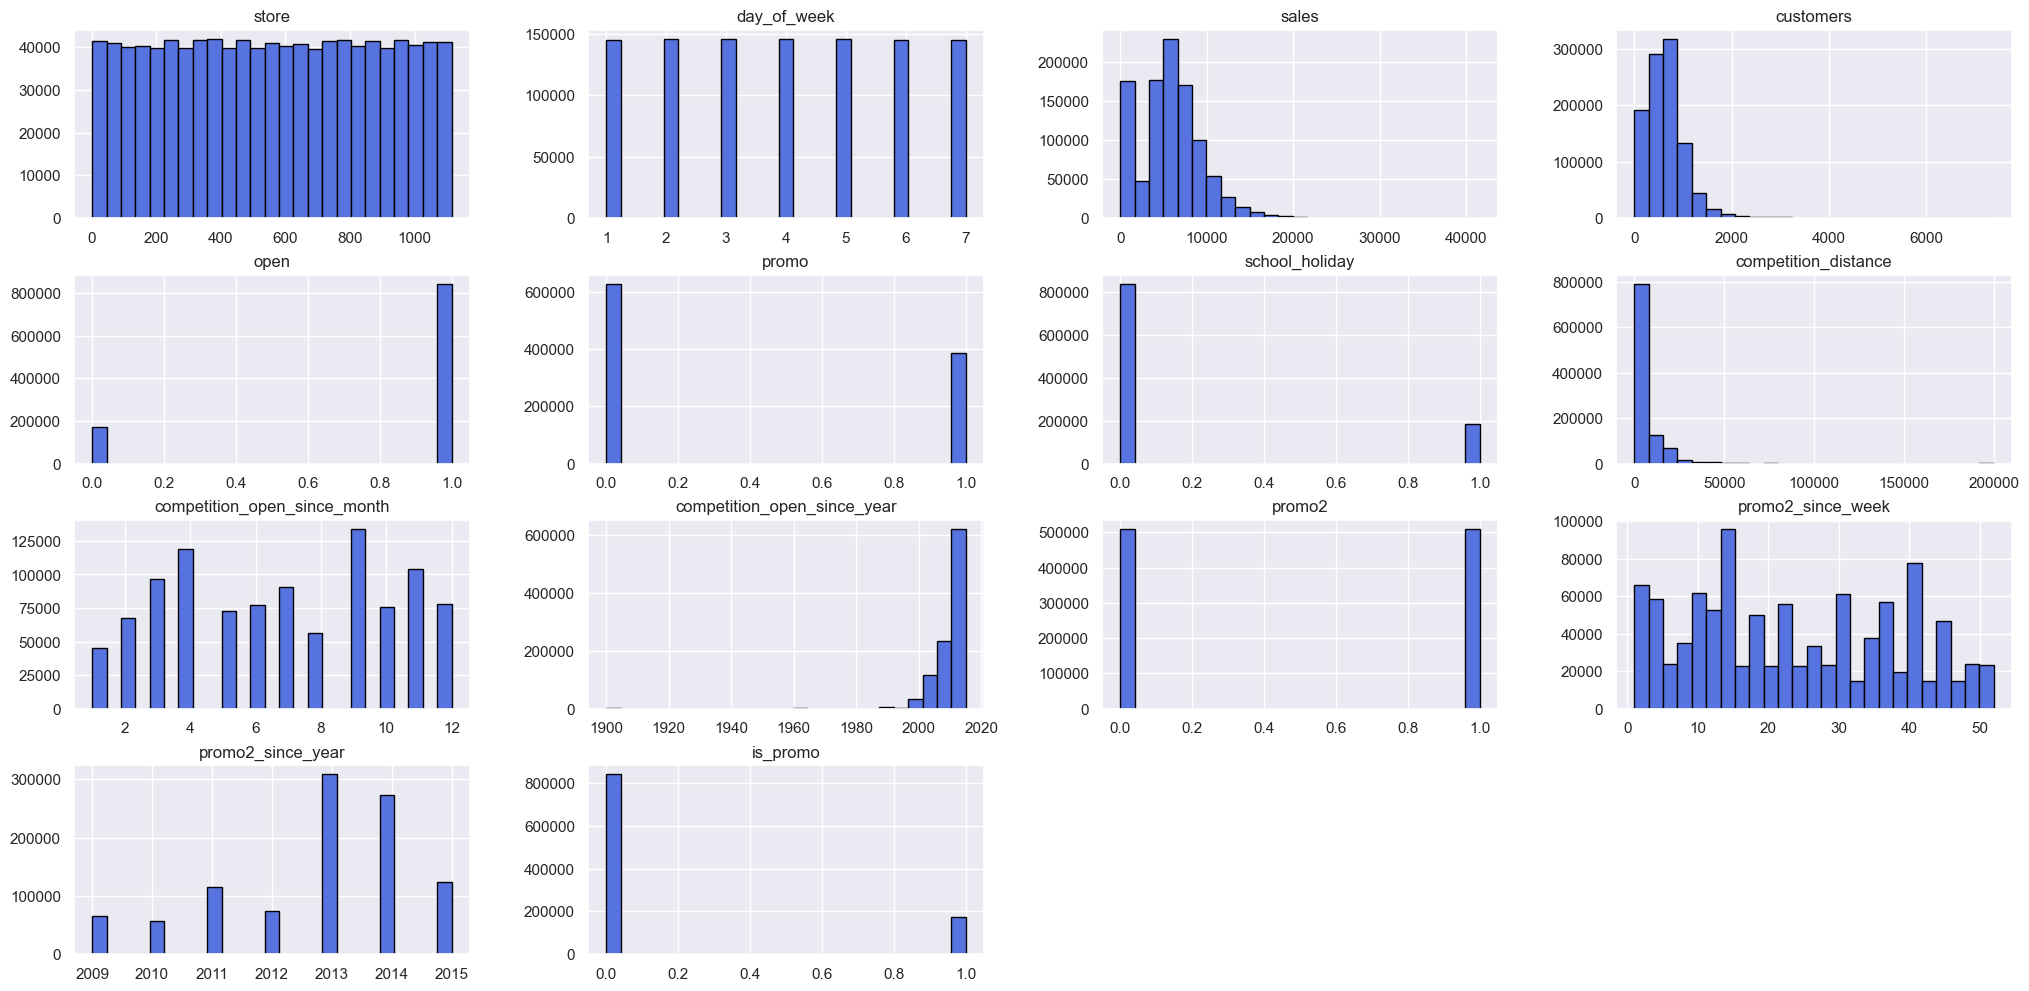

In [24]:
color = sns.color_palette('coolwarm', n_colors=10)[0]
num_attributes.hist(bins= 25,color=color, alpha=1, edgecolor= 'black');

### 4.1.3 CATEGORICAL VARIABLE

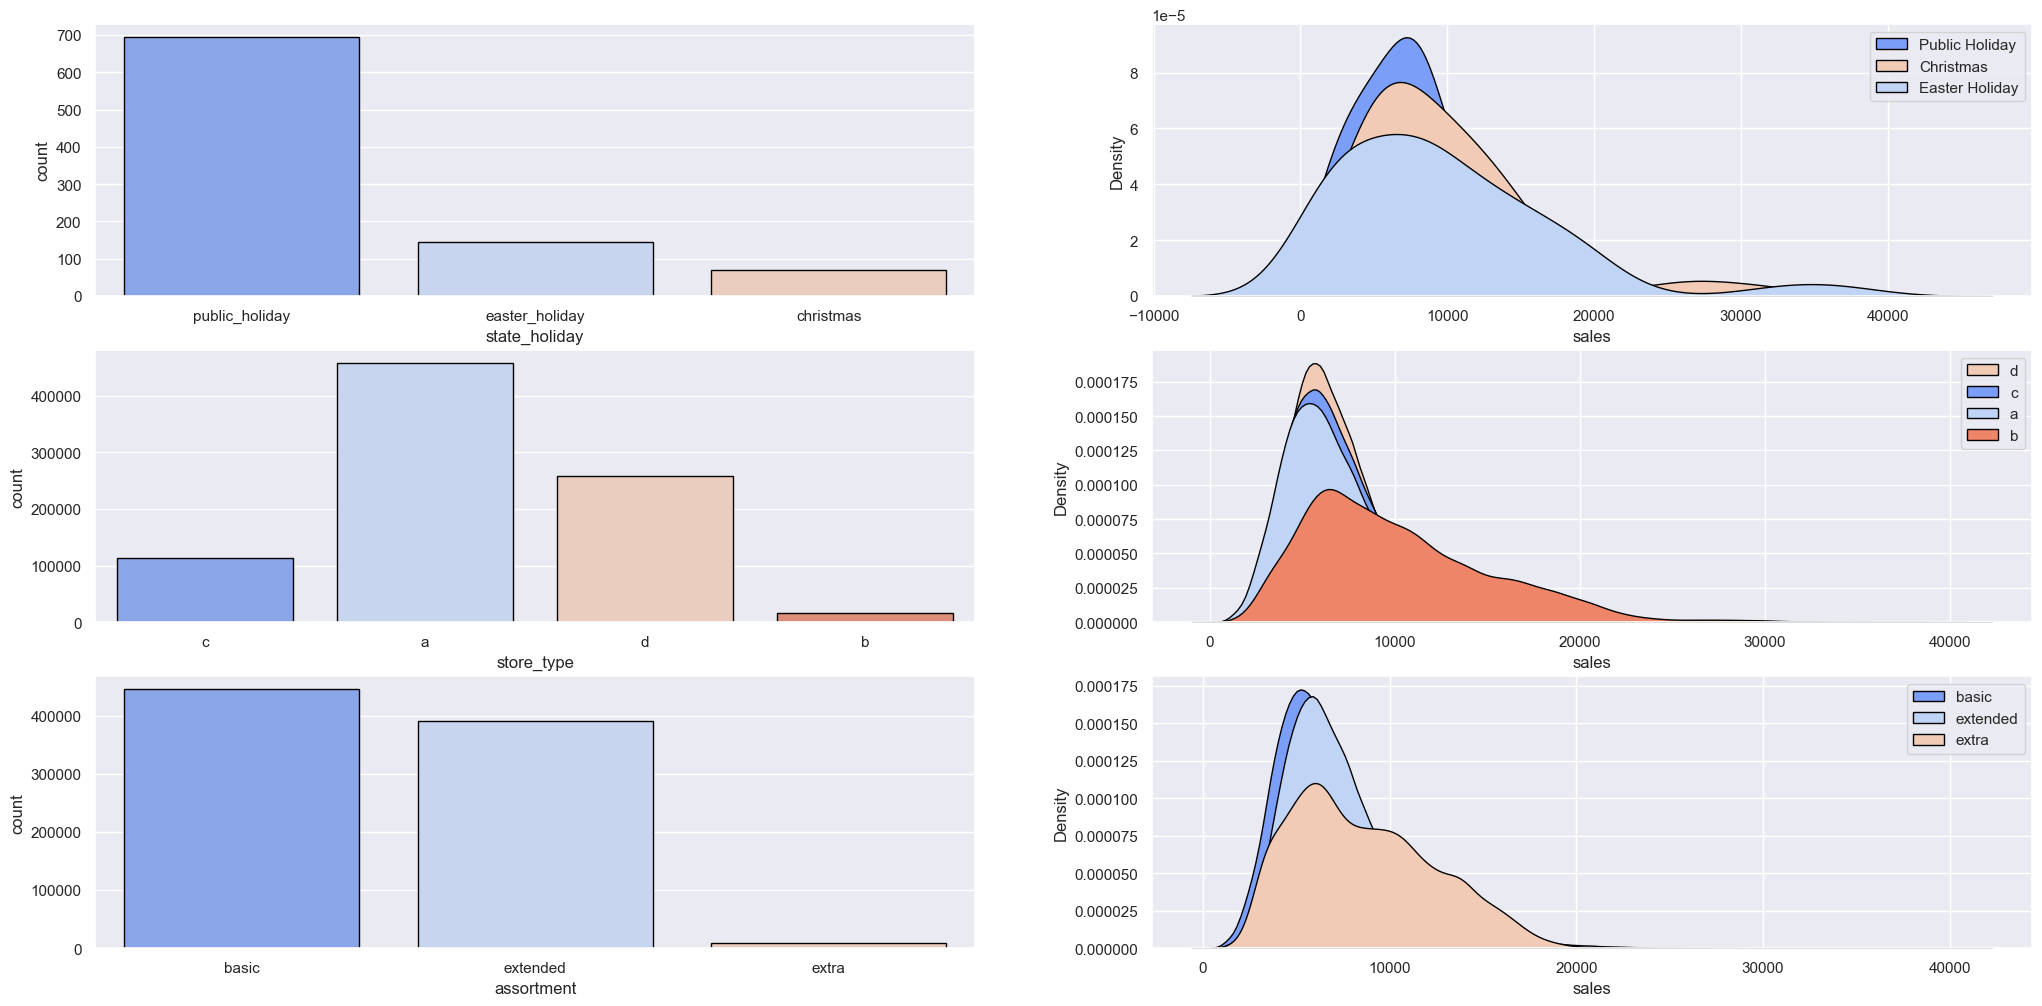

In [25]:
color = sns.color_palette('coolwarm', n_colors=4)

# state_holiday
df4['state_holiday'].drop_duplicates()

plt.subplot(3, 2, 1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'], palette = color, alpha = 1, edgecolor= 'black')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='Public Holiday', color= color[0], alpha=1, fill=True, edgecolor='black')
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='Christmas', color= color[2], alpha=1, fill=True, edgecolor='black')
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='Easter Holiday',color= color[1], alpha=1,fill=True, edgecolor='black')
plt.legend();

# store_type
df4['store_type'].drop_duplicates()

plt.subplot(3, 2, 3)
sns.countplot(x=df4['store_type'], palette= color, alpha = 1, edgecolor= 'black')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', color= color[2], alpha=1, fill=True, edgecolor='black')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', color= color[0], alpha=1, fill=True, edgecolor='black')
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', color= color[1], alpha=1, fill=True, edgecolor='black')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', color= color[3], alpha=1, fill=True, edgecolor='black')
plt.legend()

# assortment
df4['assortment'].drop_duplicates()

plt.subplot(3, 2, 5)
sns.countplot(x=df4['assortment'], palette= color, alpha = 1, edgecolor= 'black')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', color= color[0], alpha=1,fill=True, edgecolor='black')
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', color= color[1], alpha=1,fill=True, edgecolor='black')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', color= color[2], alpha=1, fill=True, edgecolor='black')
plt.legend();



## 4.2. BIVARIATE ANALYSIS

#### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com maior SORTIMENTO vendem MENOS.

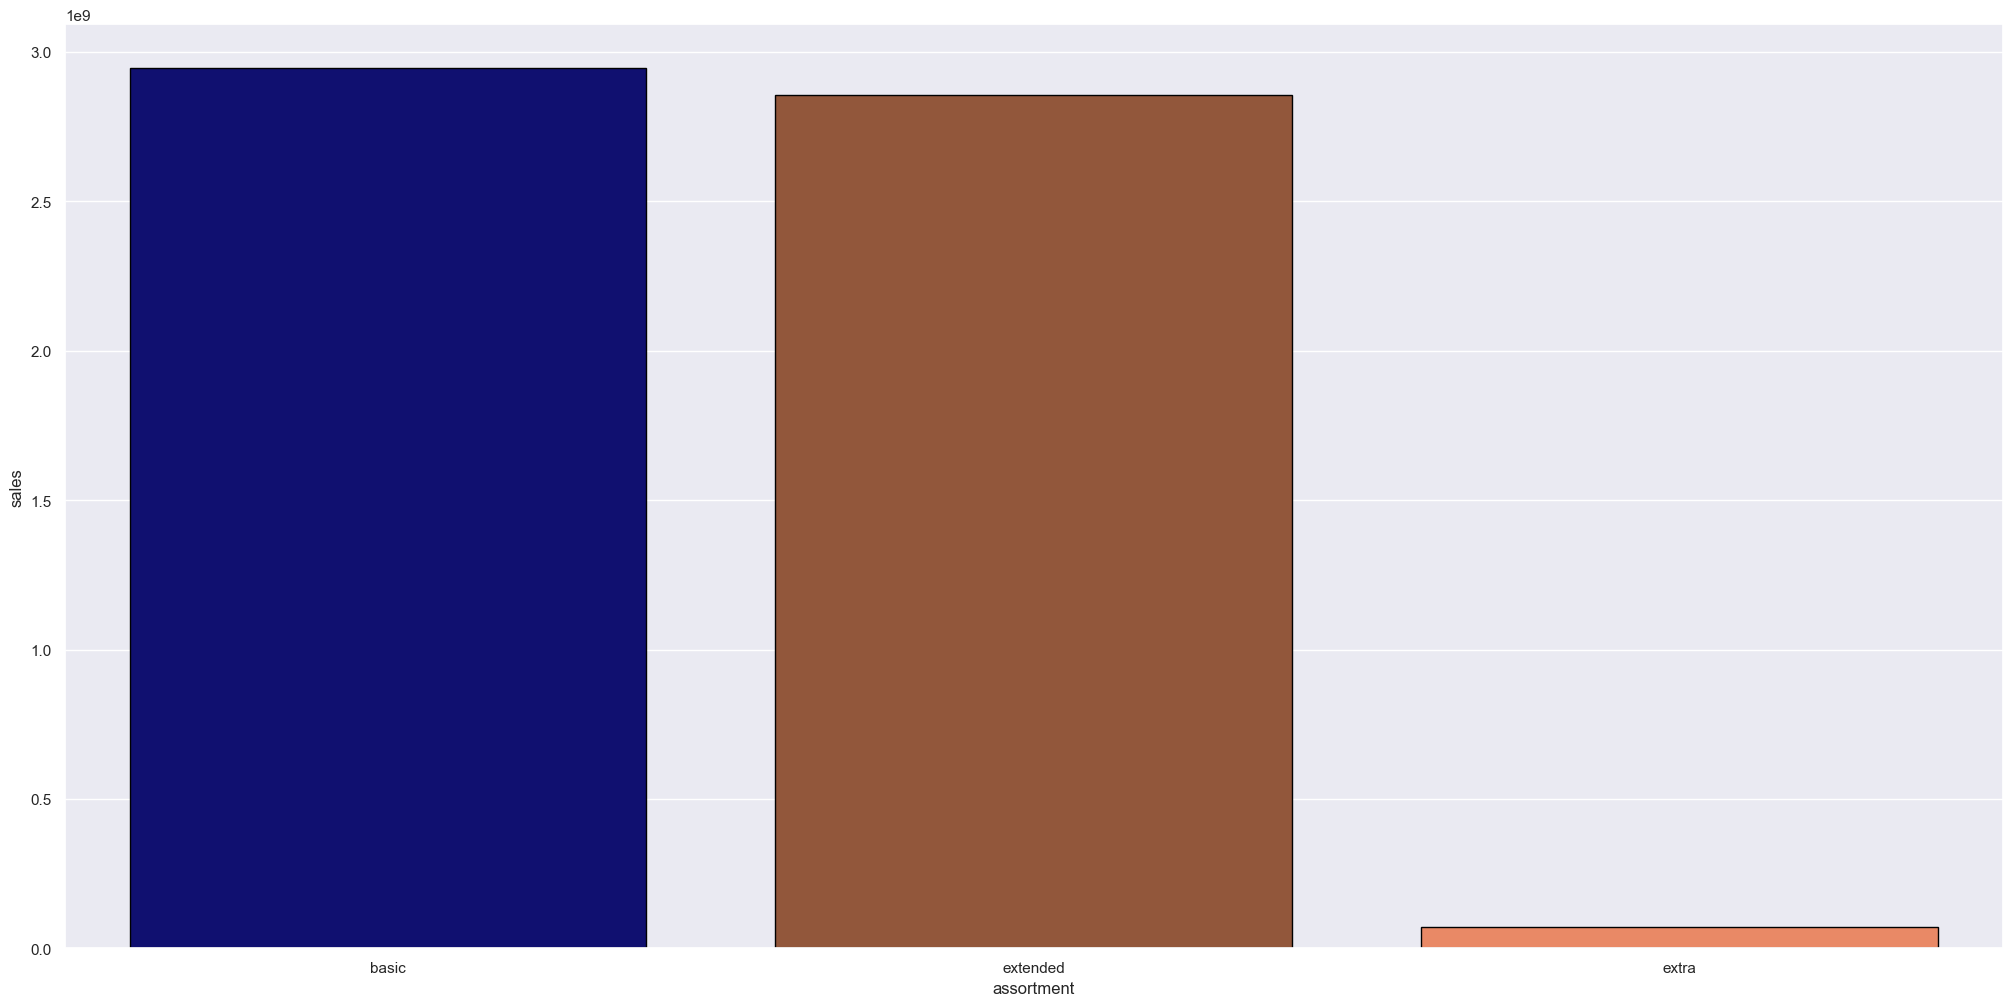

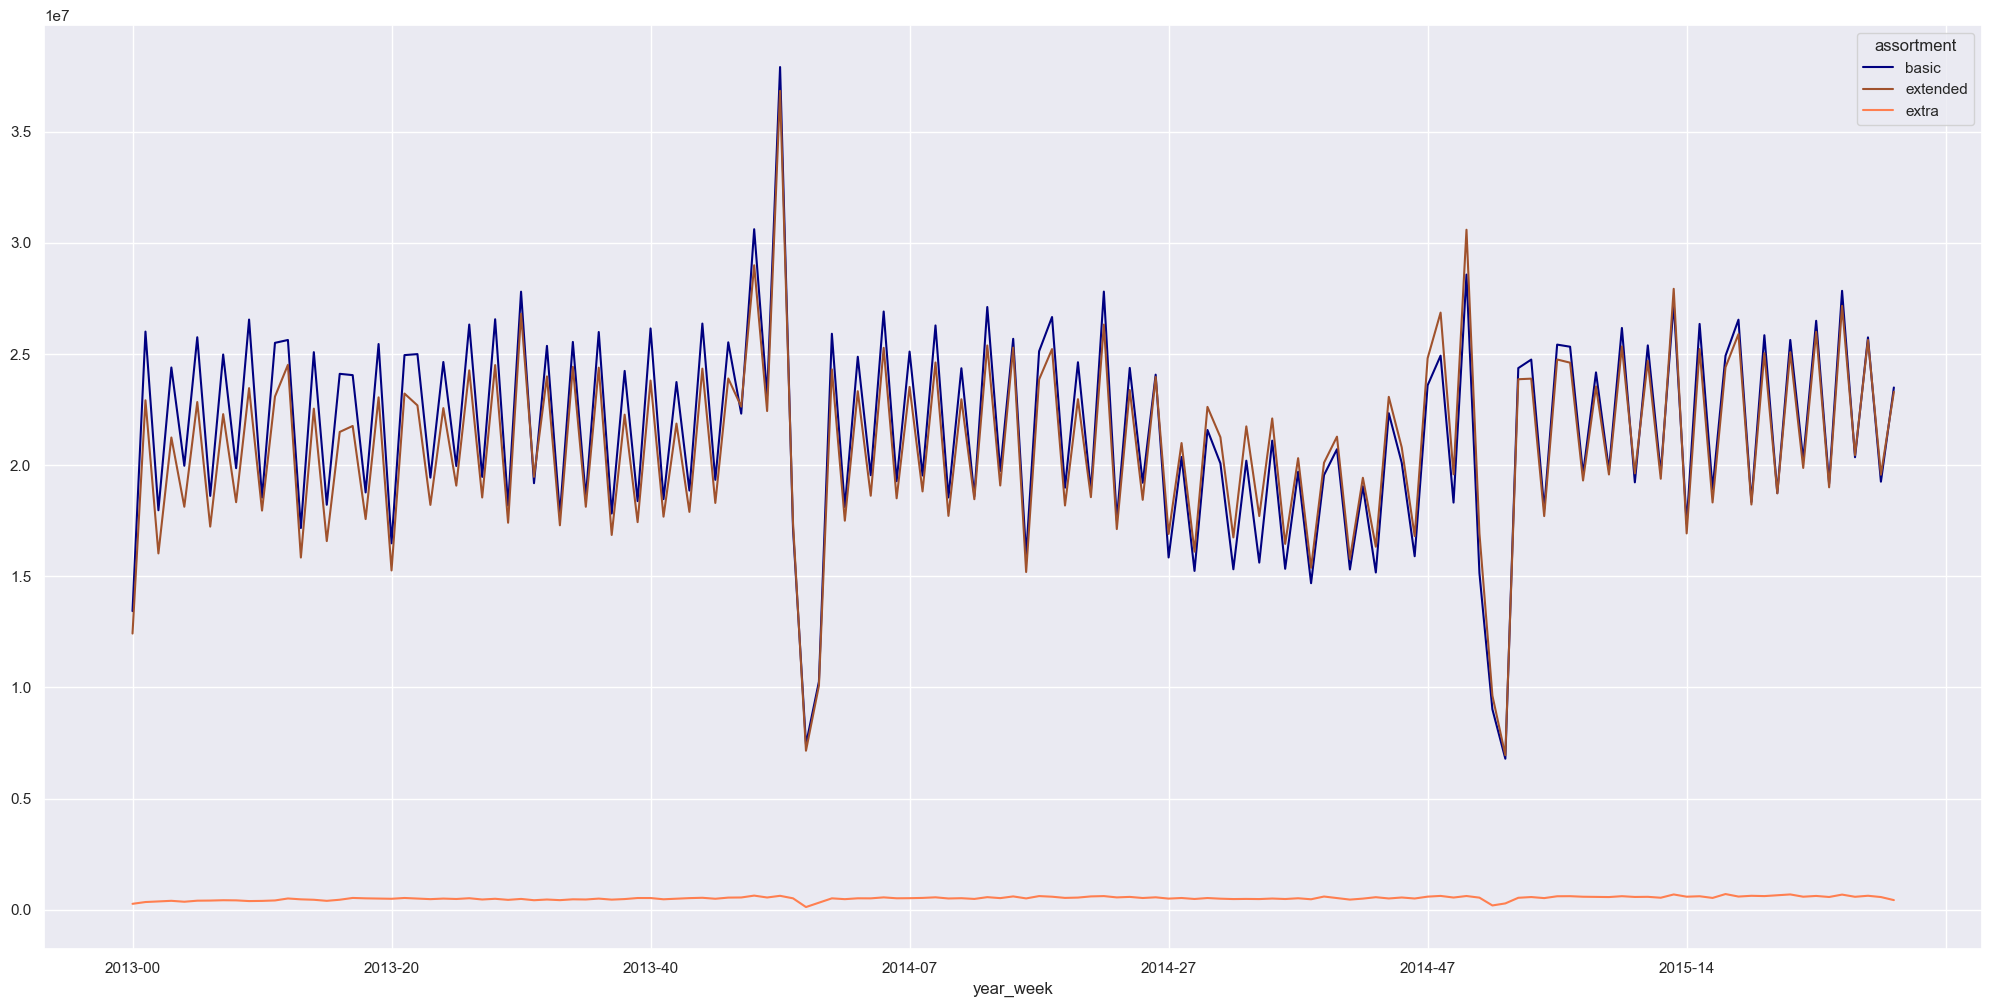

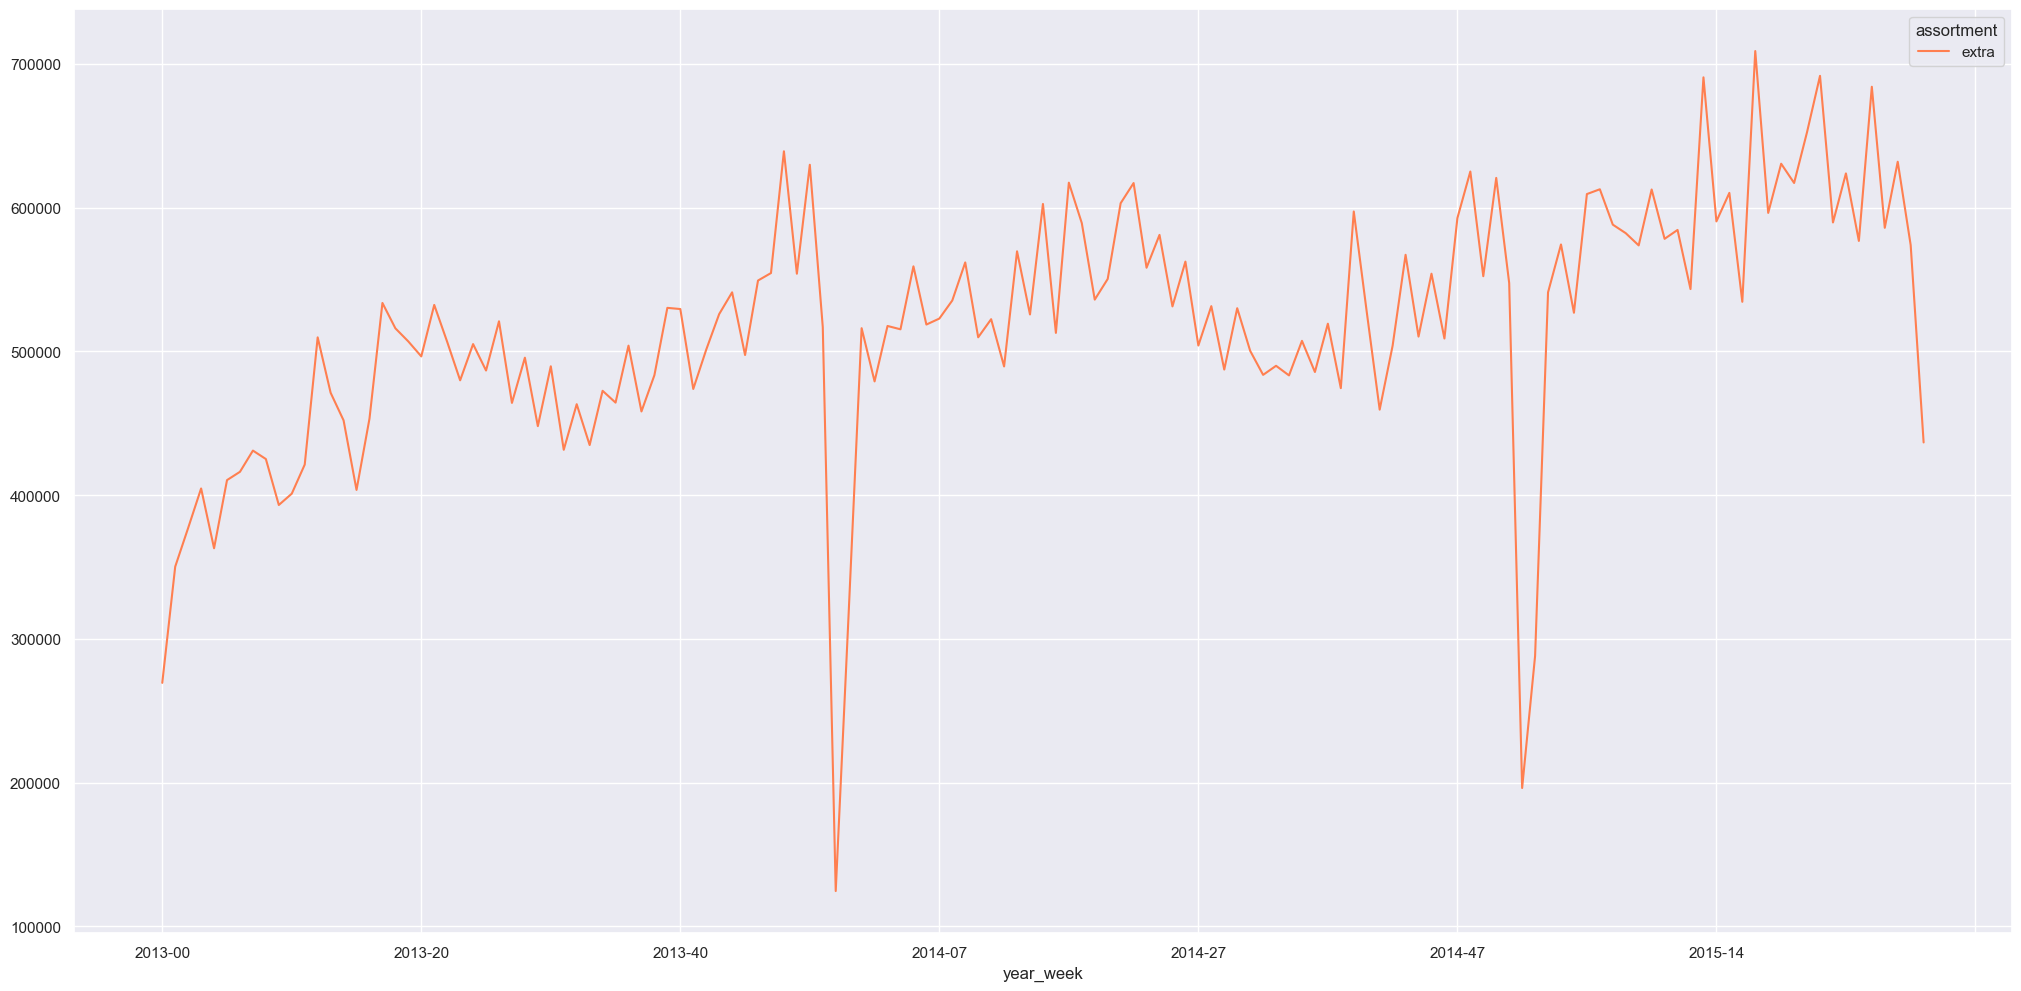

In [26]:
colors = [ 'Navy','sienna','coral']

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y= 'sales', data= aux1, palette= colors, edgecolor='black', alpha=1)

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot(color= colors, alpha=1);

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot(color= 'coral', alpha=1);

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

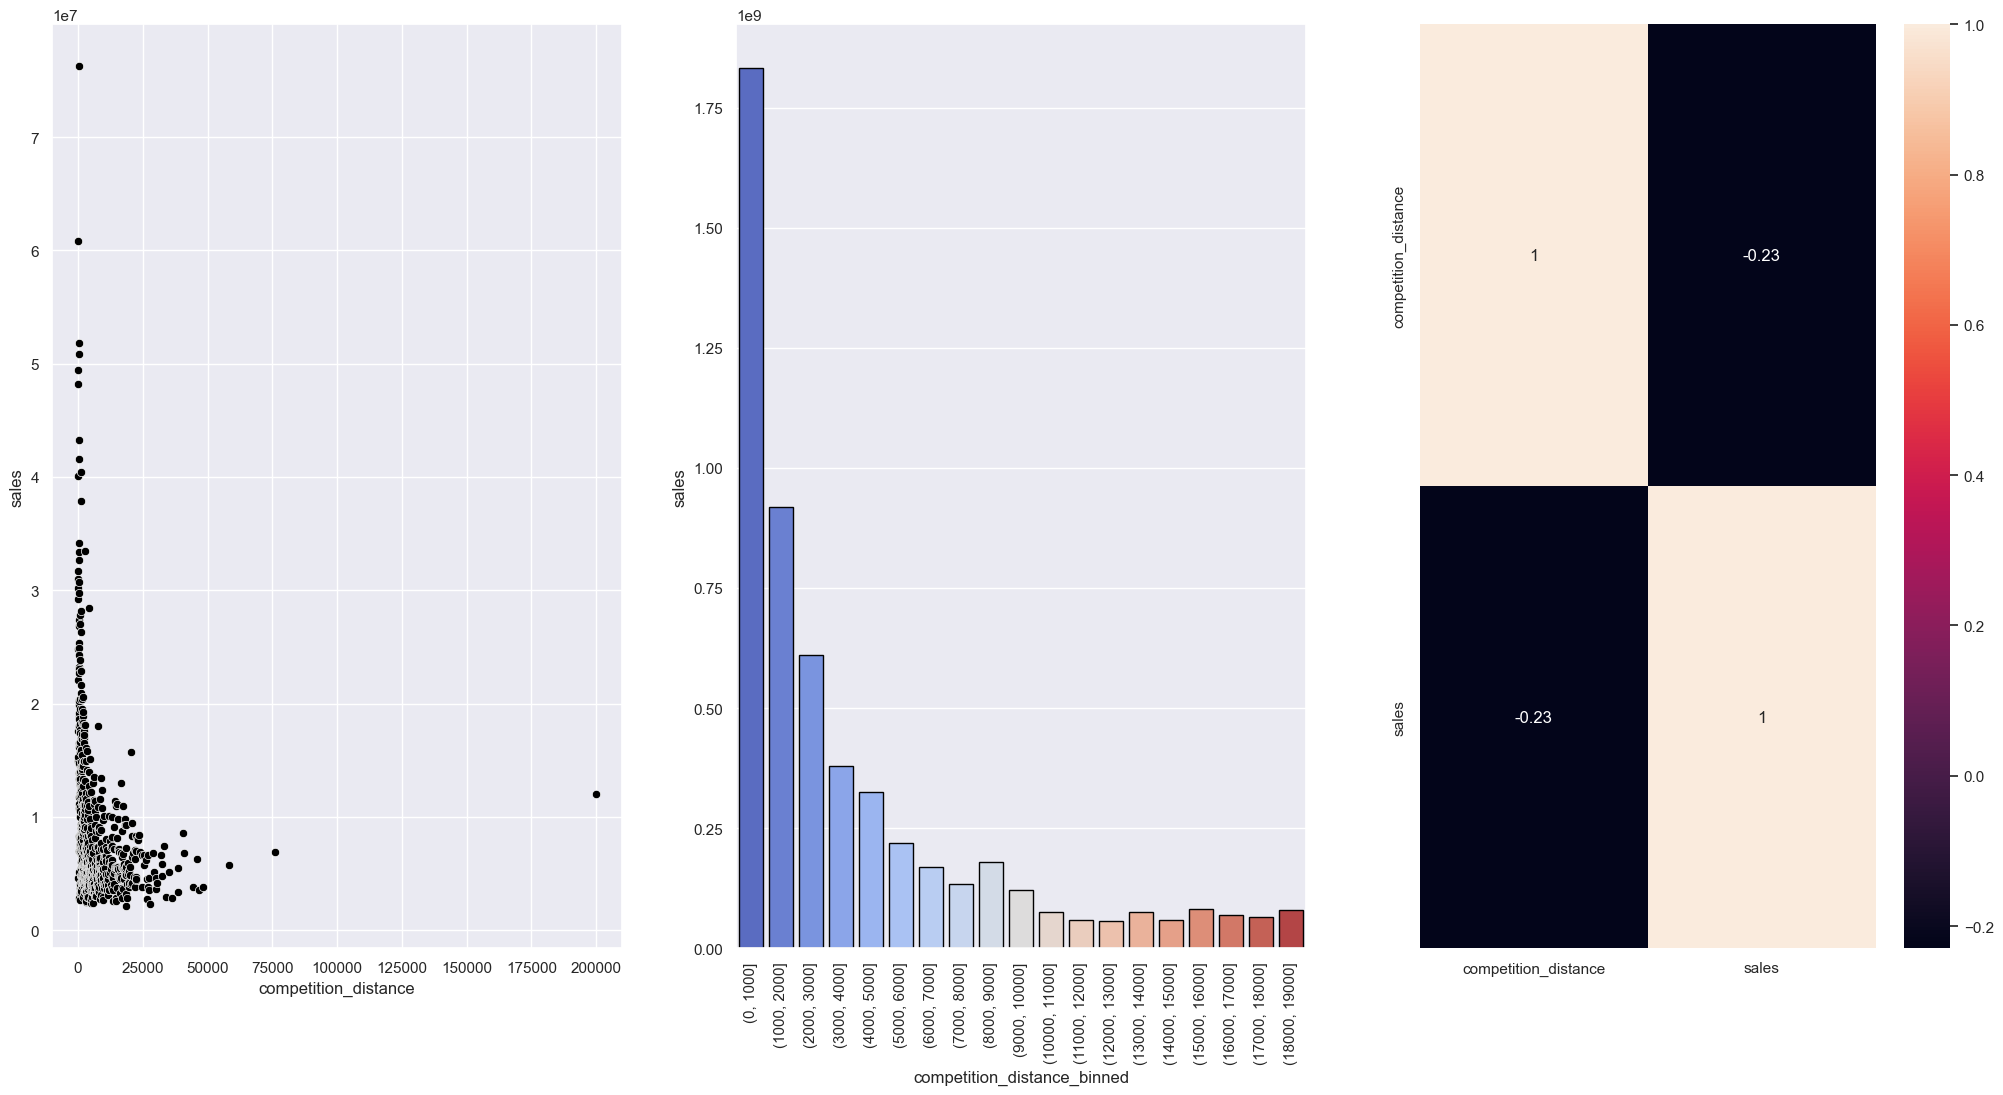

In [27]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot( x='competition_distance', y='sales', data=aux1, color= 'black', edgecolor='white', alpha=1);

plt.subplot(1, 3, 2)
bins= list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned', y= 'sales', data=aux2, edgecolor='black', alpha=1, palette= 'coolwarm');
plt.xticks( rotation= 90)

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method= 'pearson'), annot=True);


#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

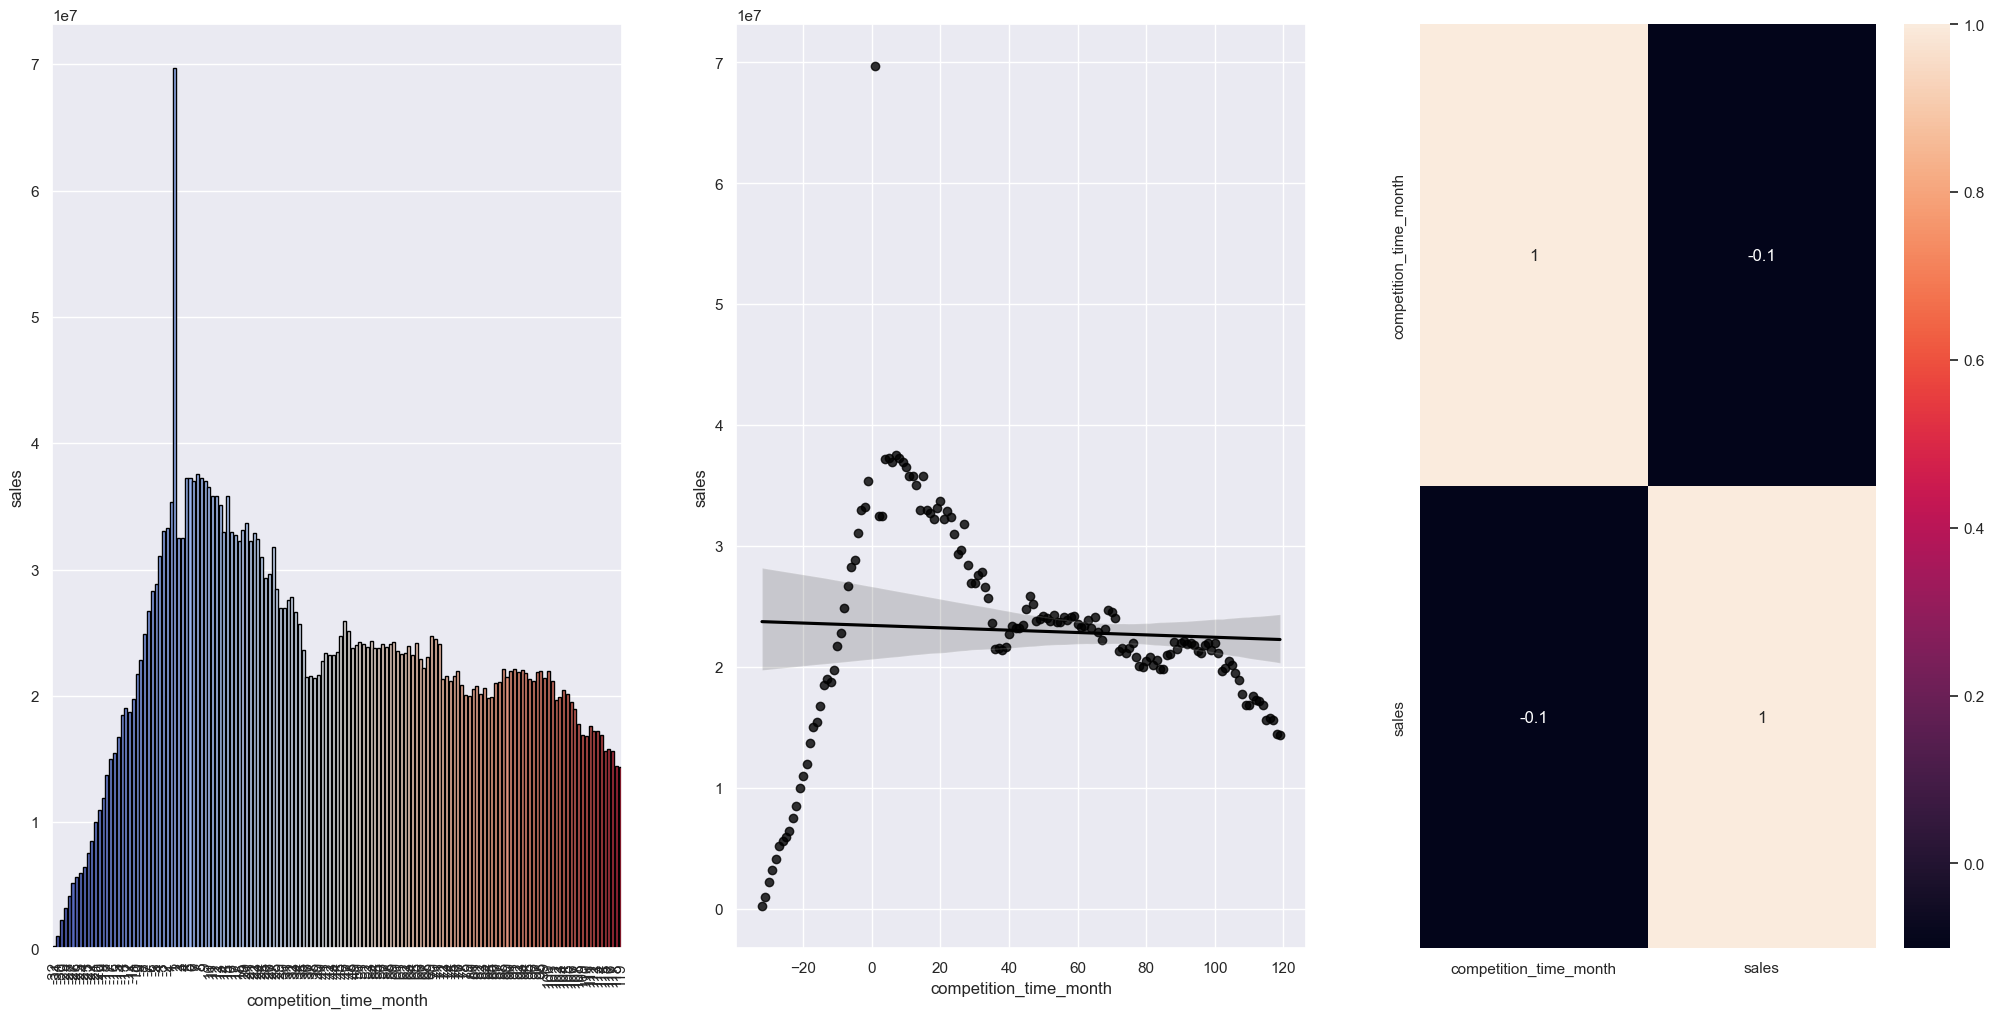

In [28]:
plt.subplot(1, 3, 1)
aux1= df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot( x='competition_time_month', y='sales', data=aux2, palette= 'coolwarm', edgecolor='black', alpha=1 );
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2, color= 'black');

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr(method='pearson'), annot=True);

#### **H4**. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção.

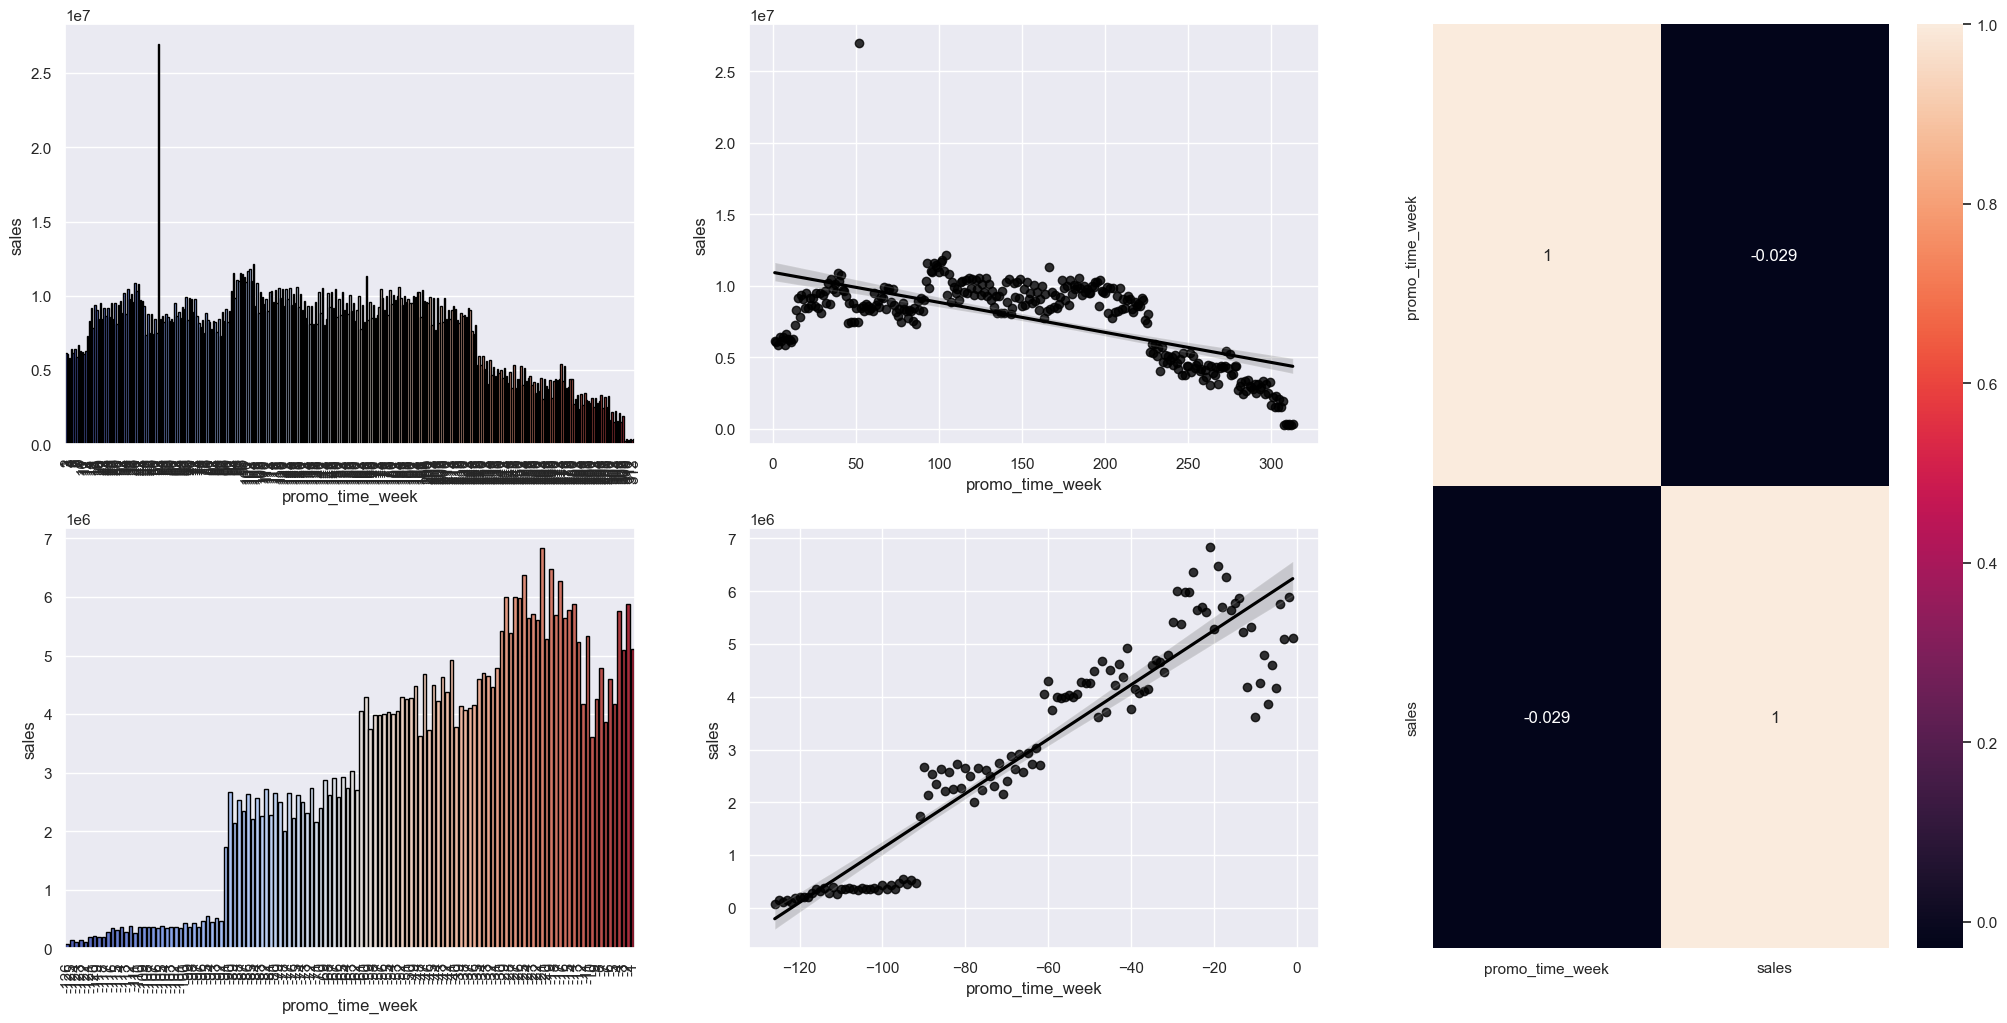

In [29]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux1)

grid = gridspec.GridSpec(2,3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux2, palette= 'coolwarm', edgecolor='black', alpha=1 );
plt.xticks( rotation= 90);

plt.subplot( grid[0,1] )
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux2, color= 'black');


plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x= 'promo_time_week', y= 'sales', data= aux3, palette= 'coolwarm', edgecolor='black', alpha=1 );
plt.xticks( rotation= 90);

plt.subplot( grid[1,1] )
sns.regplot(x= 'promo_time_week', y= 'sales', data= aux3, color= 'black');

plt.subplot( grid[:,2] )
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### <s>**H5**. Lojas com mais dias de promoção deveriam vender mais.</s>

#### **H6**. Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais promoções consecutivas vendem menos

In [30]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


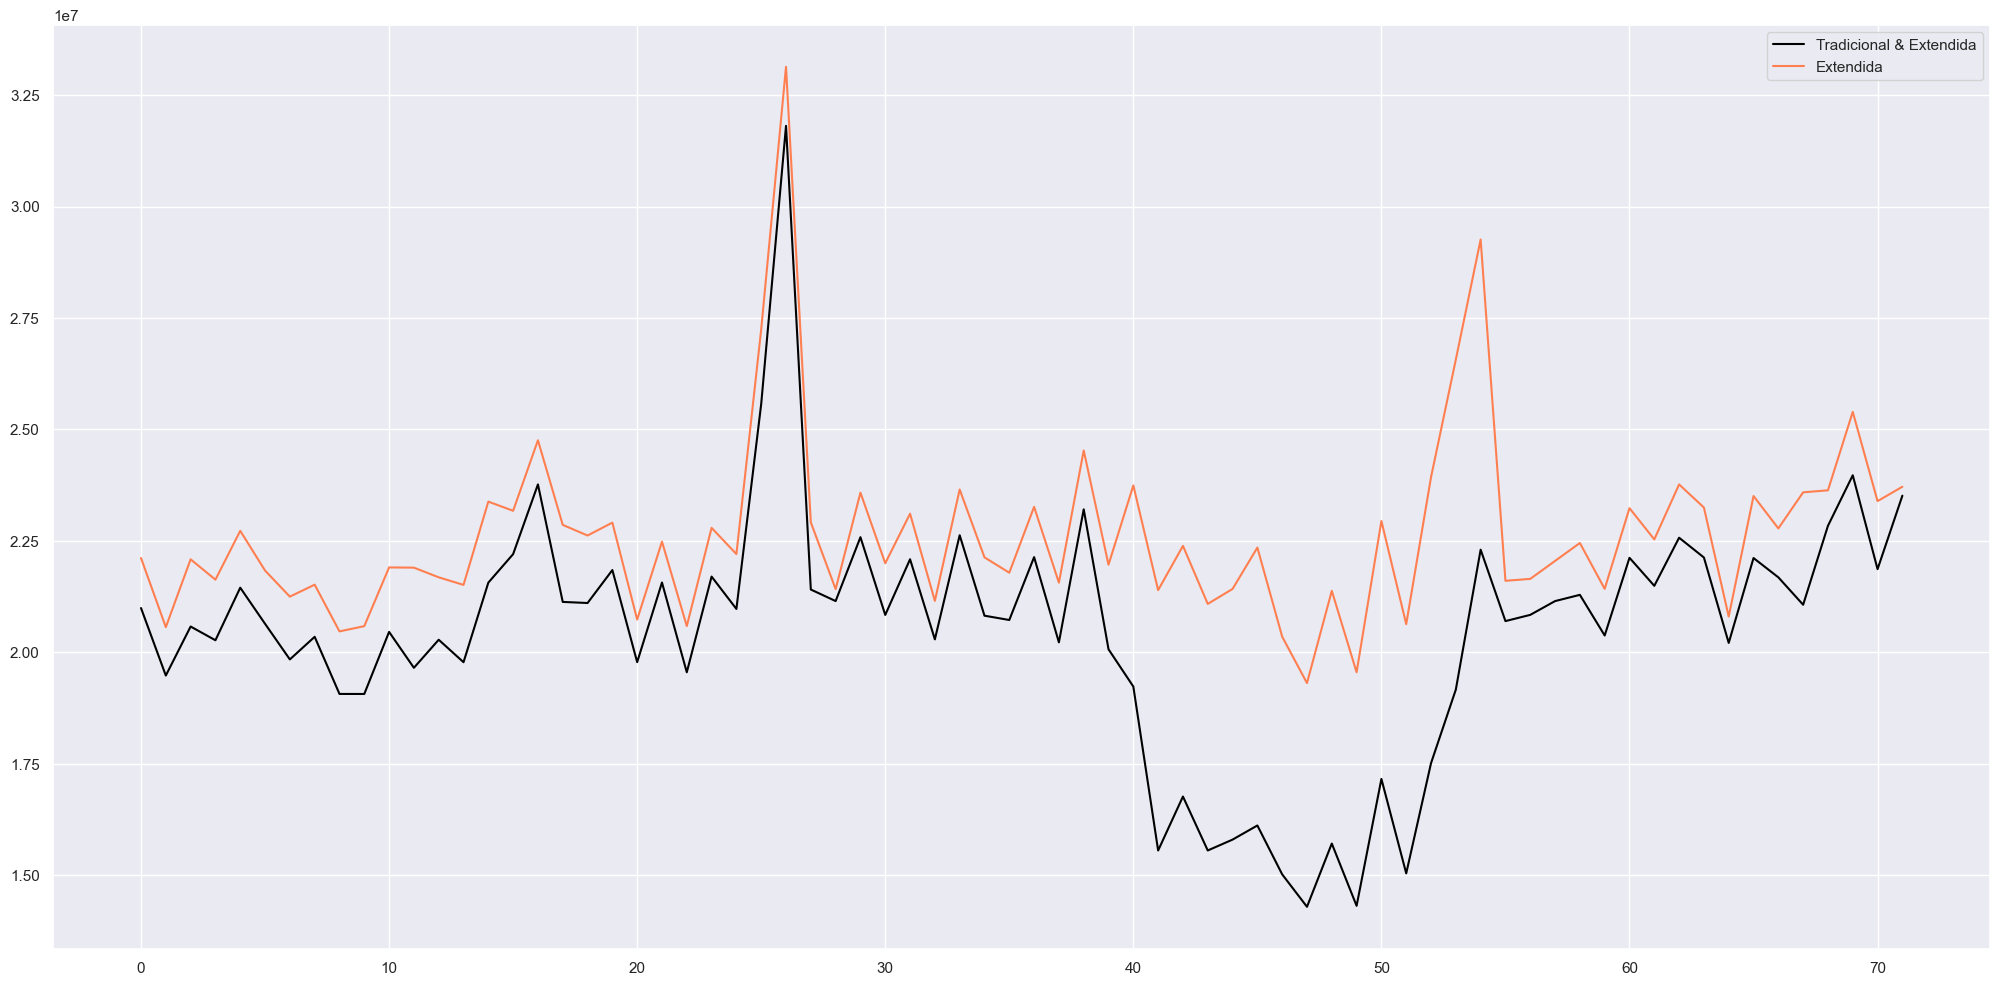

In [31]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(color= 'black', alpha=1)

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax,color= 'coral', alpha=1)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

#### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriodo do Natal vendem menos.

<AxesSubplot:xlabel='year', ylabel='sales'>

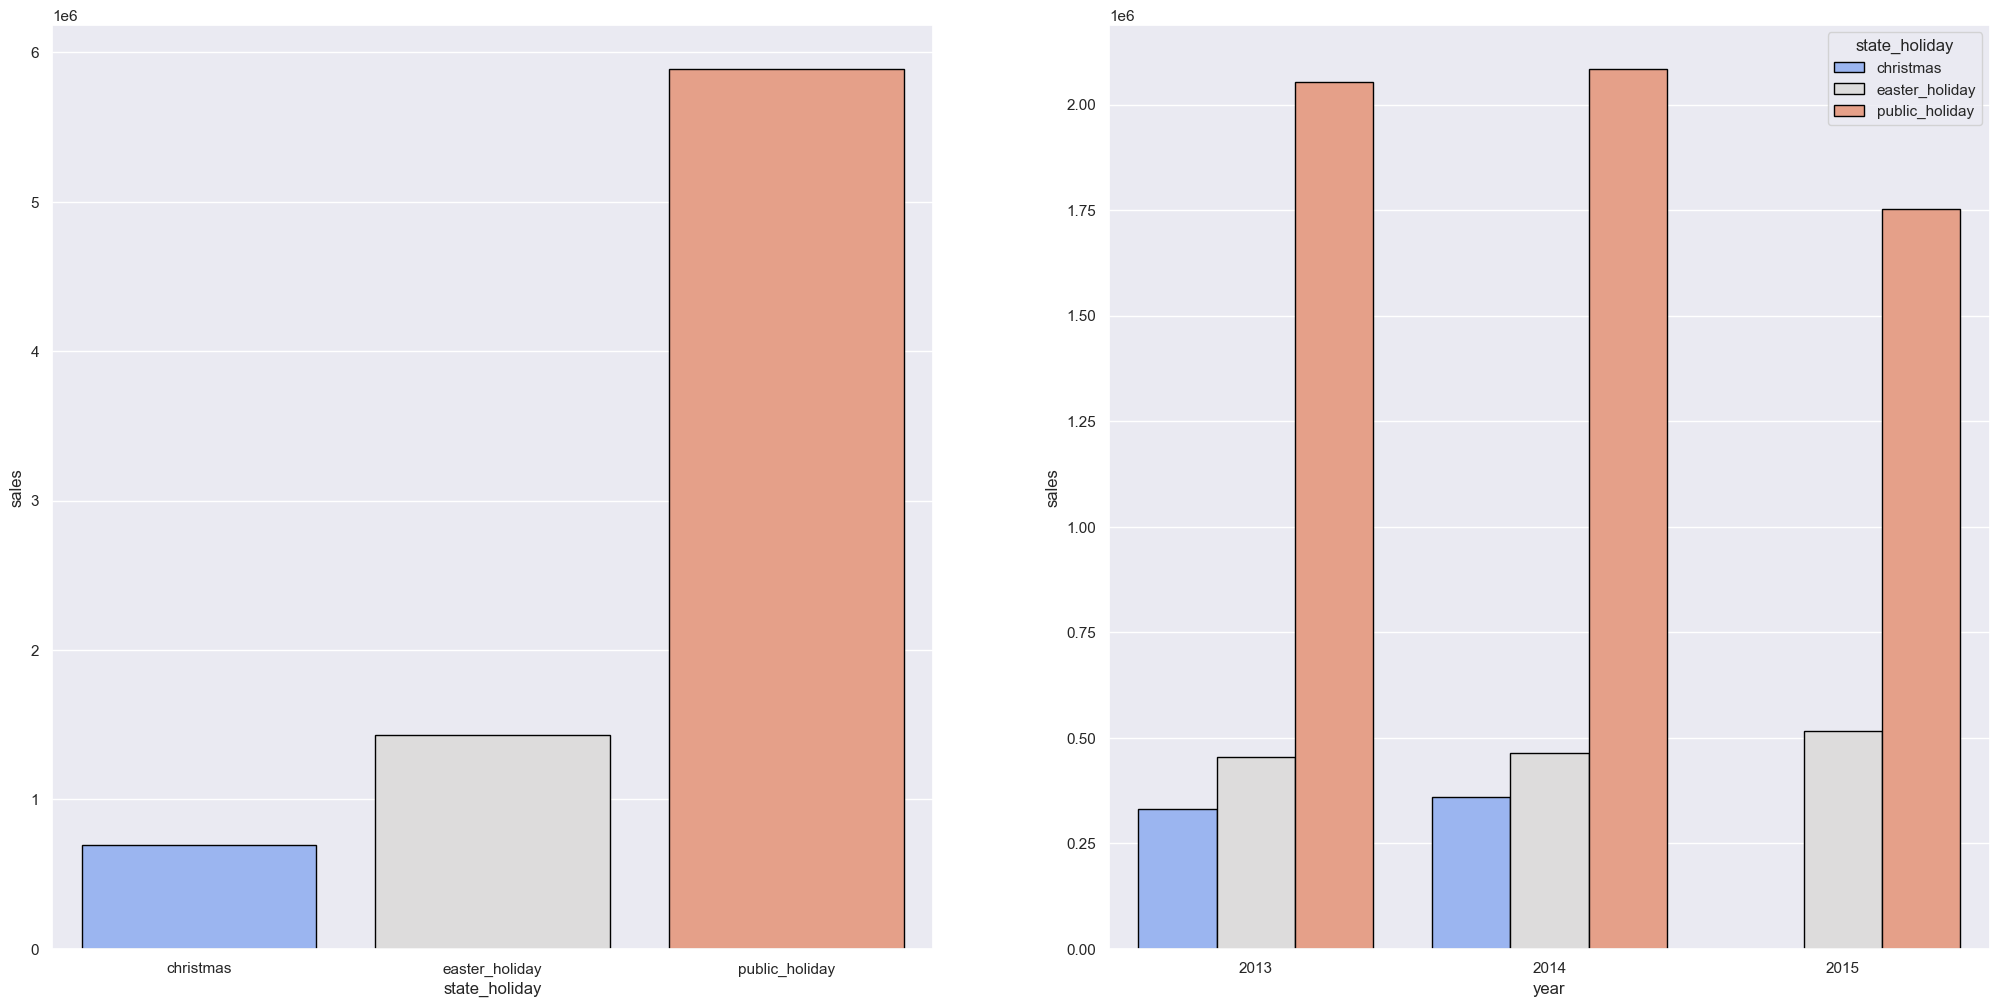

In [32]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x= 'state_holiday', y='sales', data=aux1, palette = 'coolwarm', alpha = 1, edgecolor= 'black')

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x= 'year', y='sales', hue='state_holiday', data=aux2, palette = 'coolwarm', alpha = 1, edgecolor= 'black')


#### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

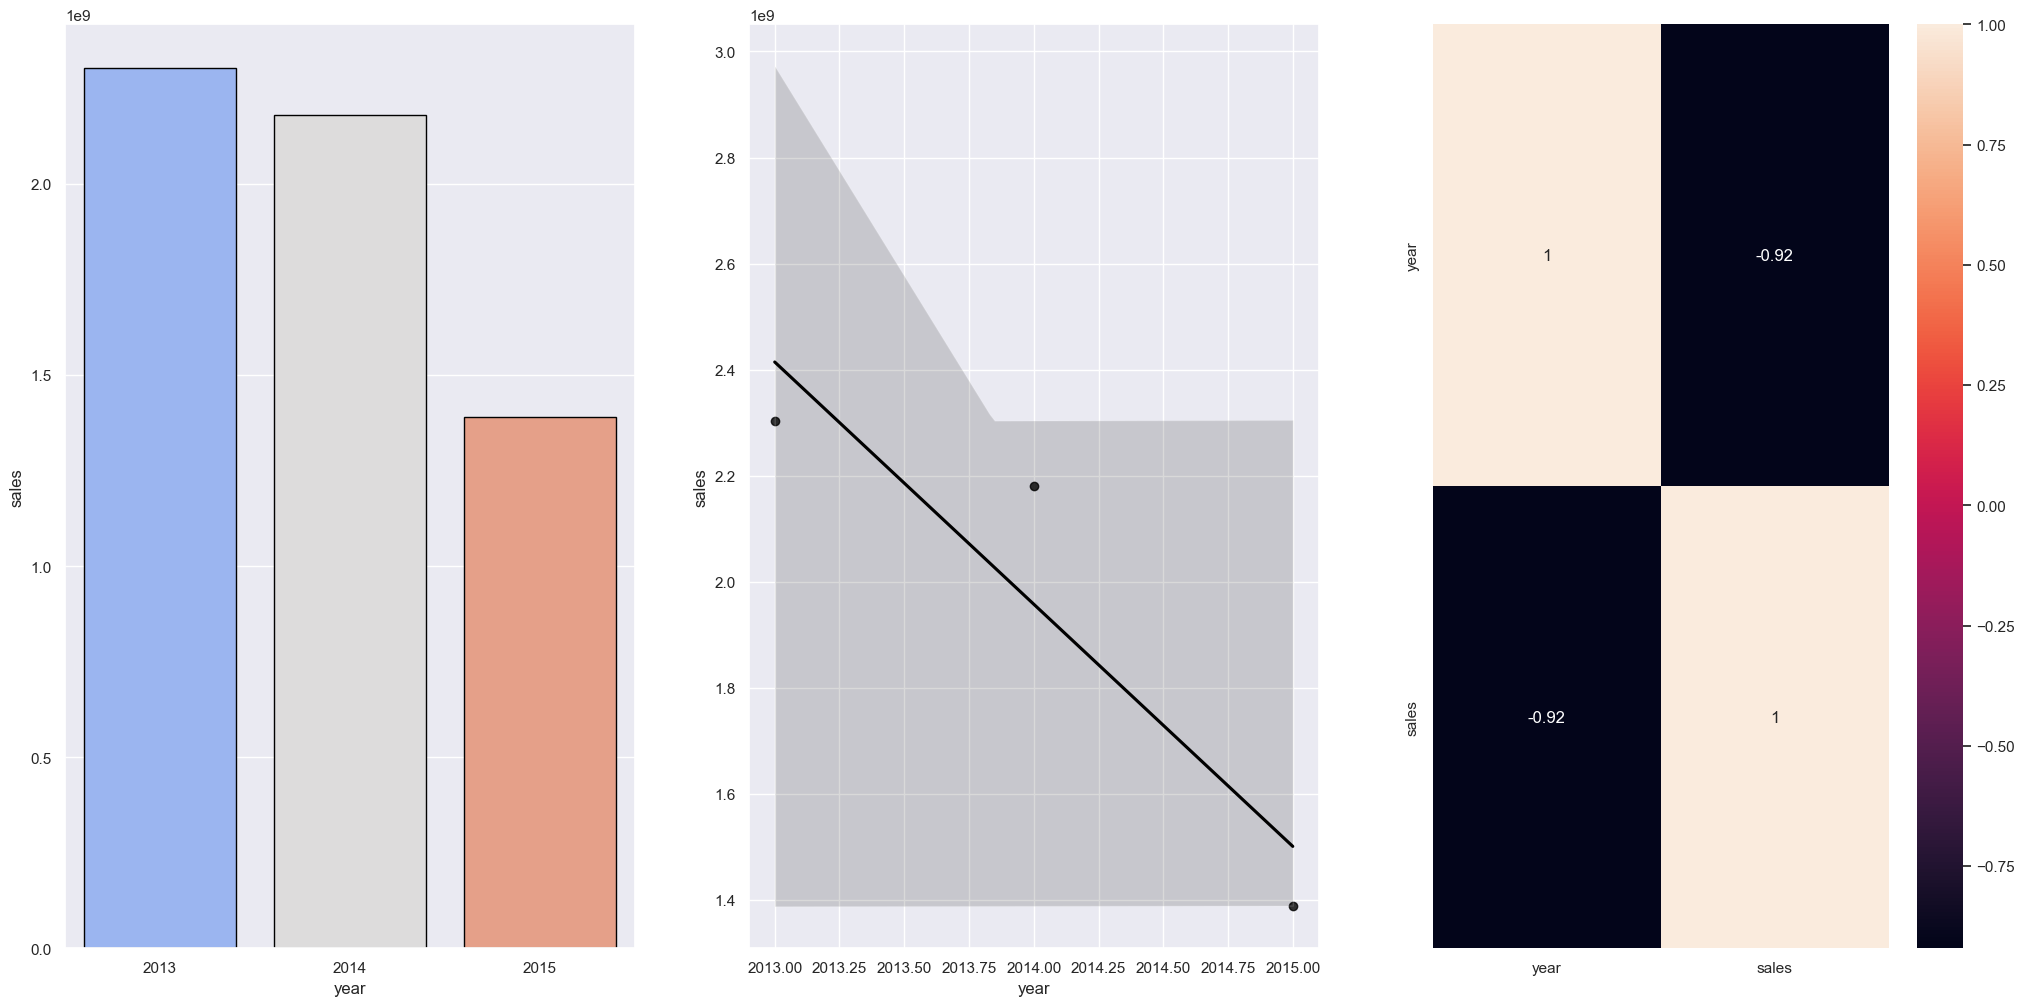

In [33]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x= 'year', y= 'sales', data=aux1, palette = 'coolwarm', alpha = 1, edgecolor= 'black')

plt.subplot(1, 3, 2)
sns.regplot(x= 'year', y= 'sales', data=aux1, color= 'black')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**VERDADE** Excluindo o ano de 2015 pois só temos dados até junho/2015. Nos anos de 2013 e 2014, as lojas **VENDERAM MAIS NO SEGUNDO SEMESTRE**.

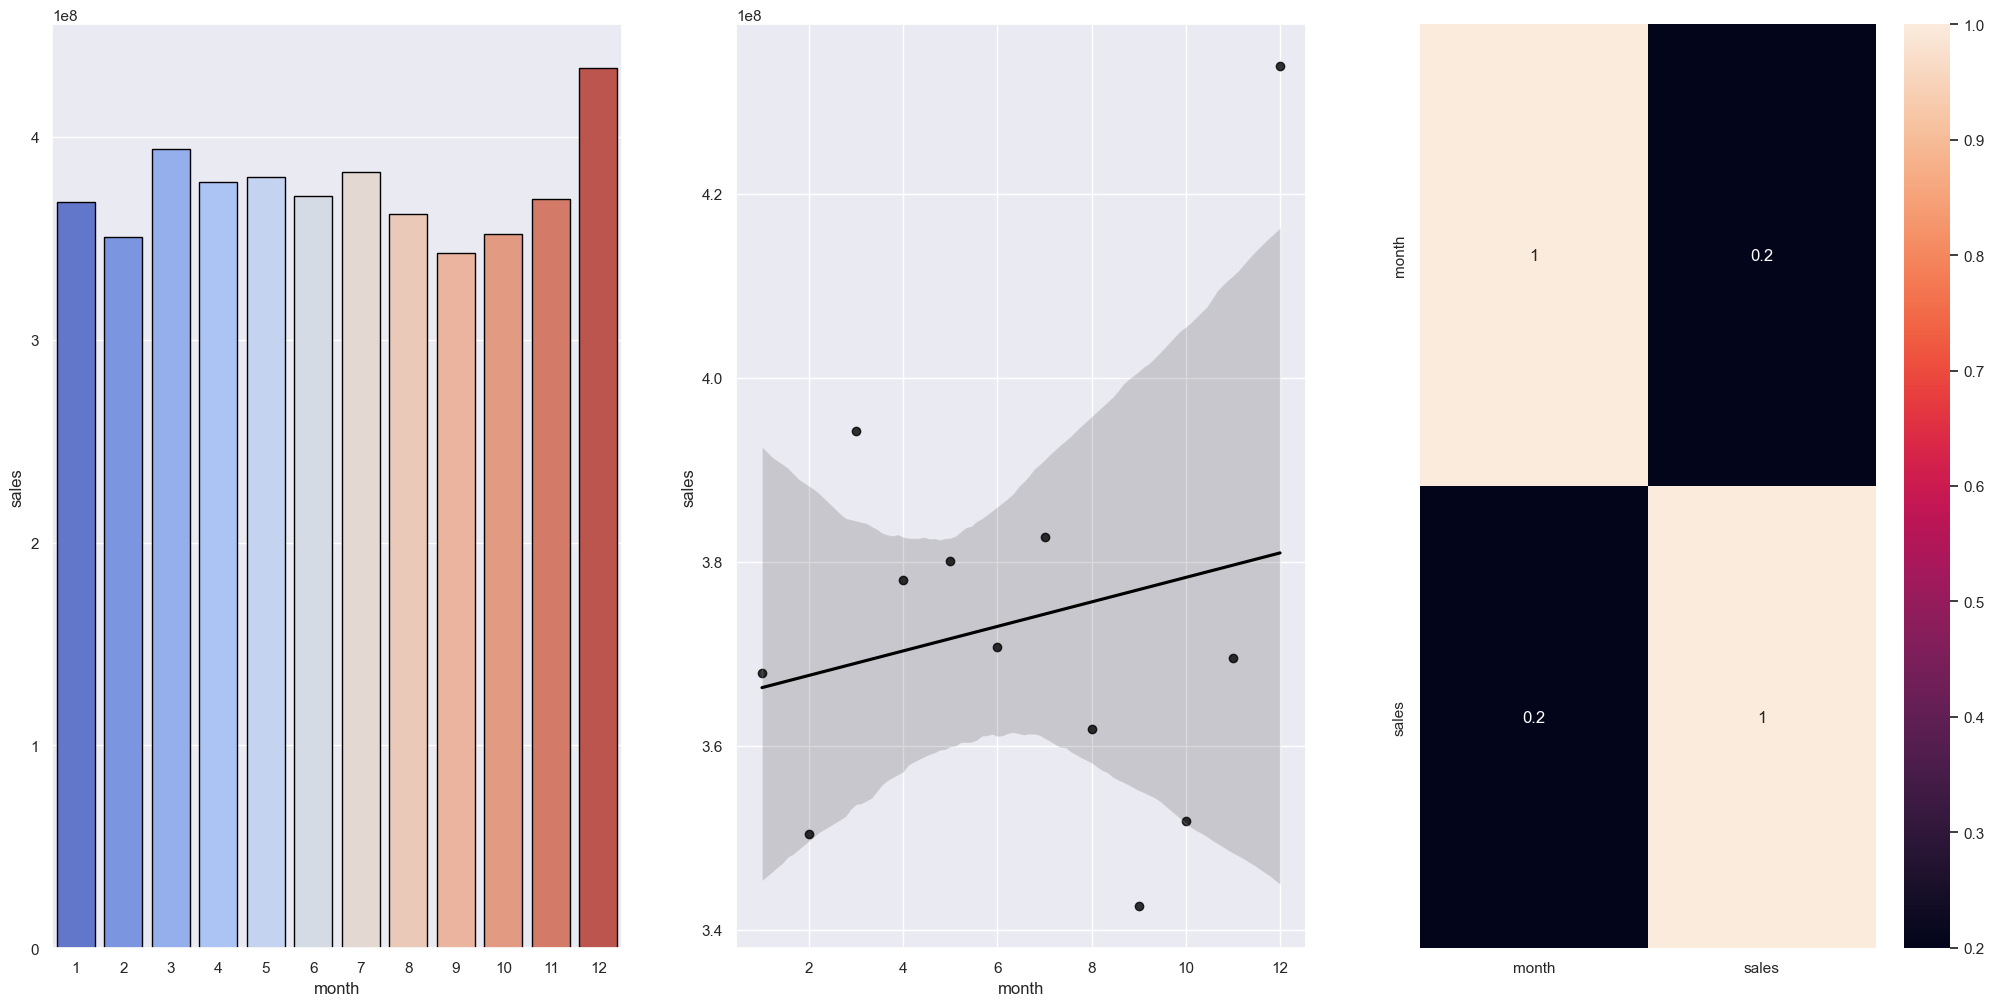

In [34]:
aux1 = df4[df4['year'] < 2015]
aux1 = aux1[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x= 'month', y= 'sales', data=aux1, palette= 'coolwarm', alpha = 1, edgecolor= 'black')

plt.subplot(1, 3, 2)
sns.regplot(x= 'month', y= 'sales', data=aux1, color= 'black')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mës.

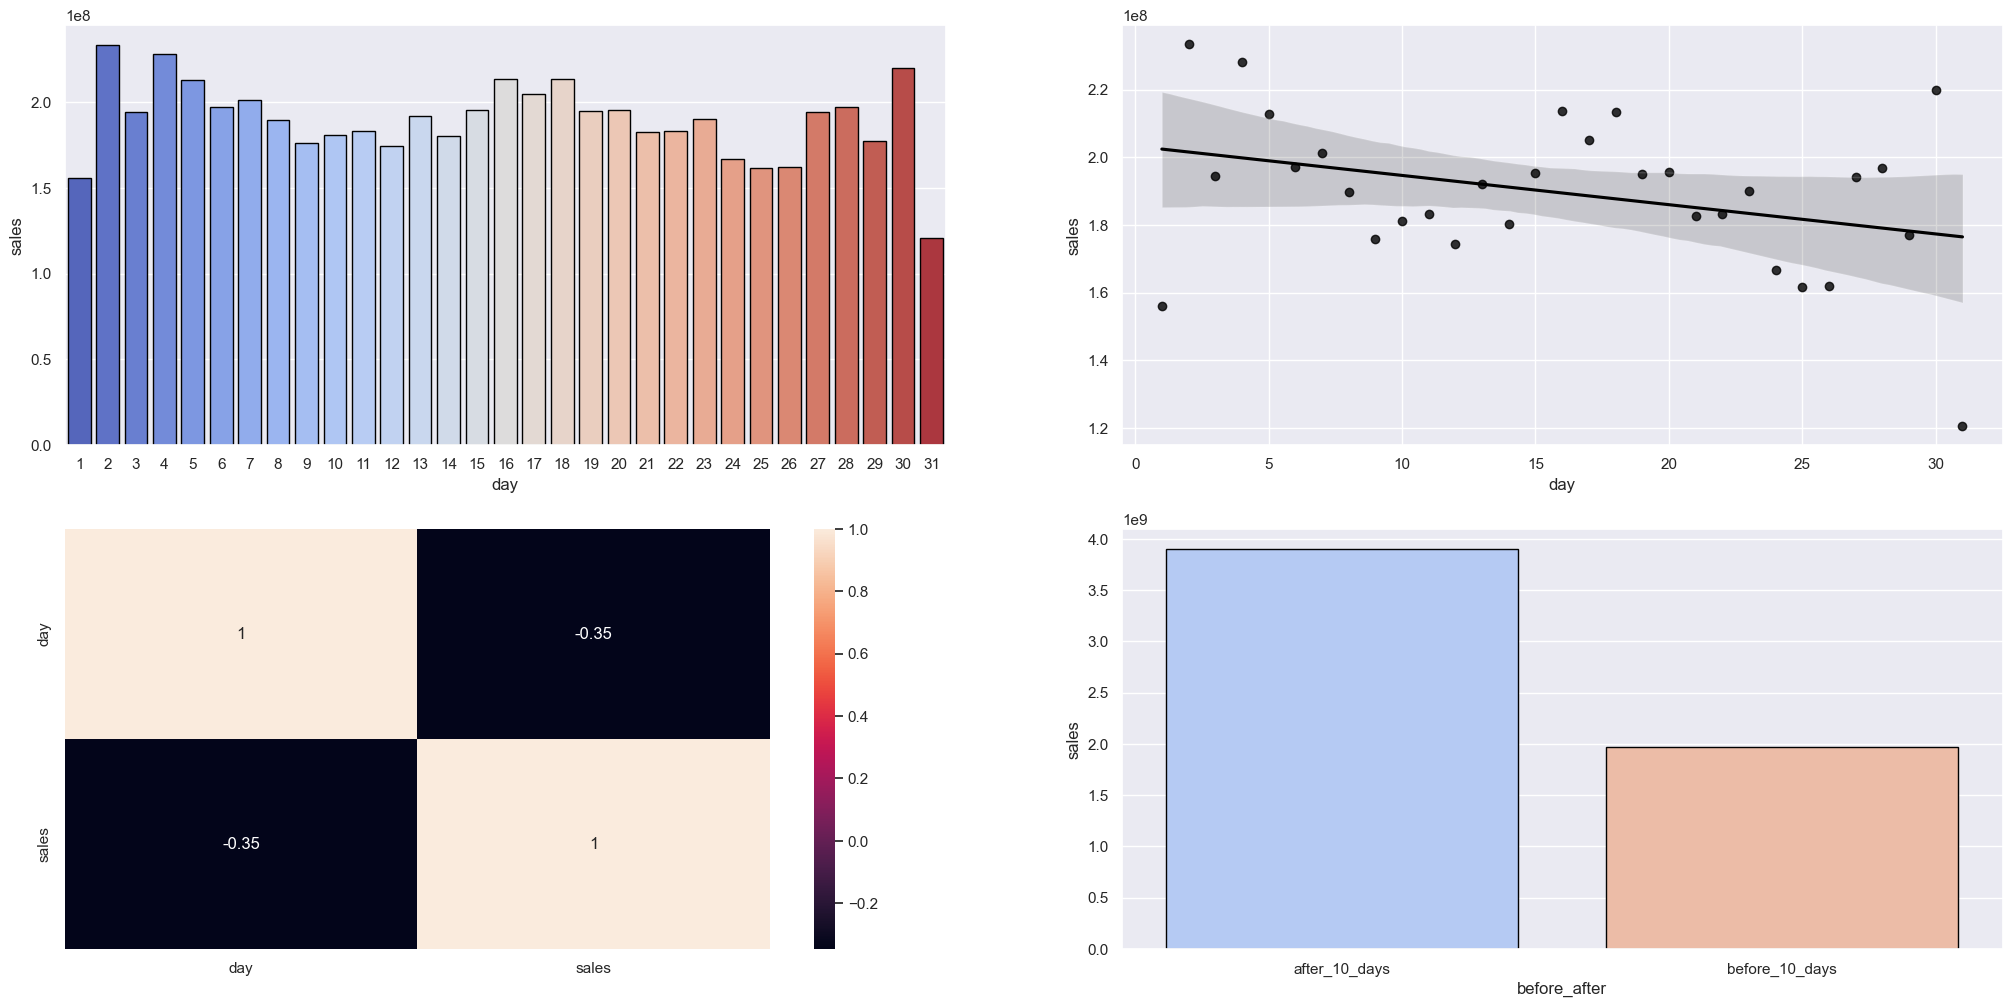

In [35]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x= 'day', y= 'sales', data=aux1, palette= 'coolwarm', alpha = 1, edgecolor= 'black')

plt.subplot(2, 2, 2)
sns.regplot(x= 'day', y= 'sales', data=aux1, color= 'black')

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x= 'before_after', y='sales', data=aux2, palette= 'coolwarm', alpha = 1, edgecolor= 'black');

#### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana.

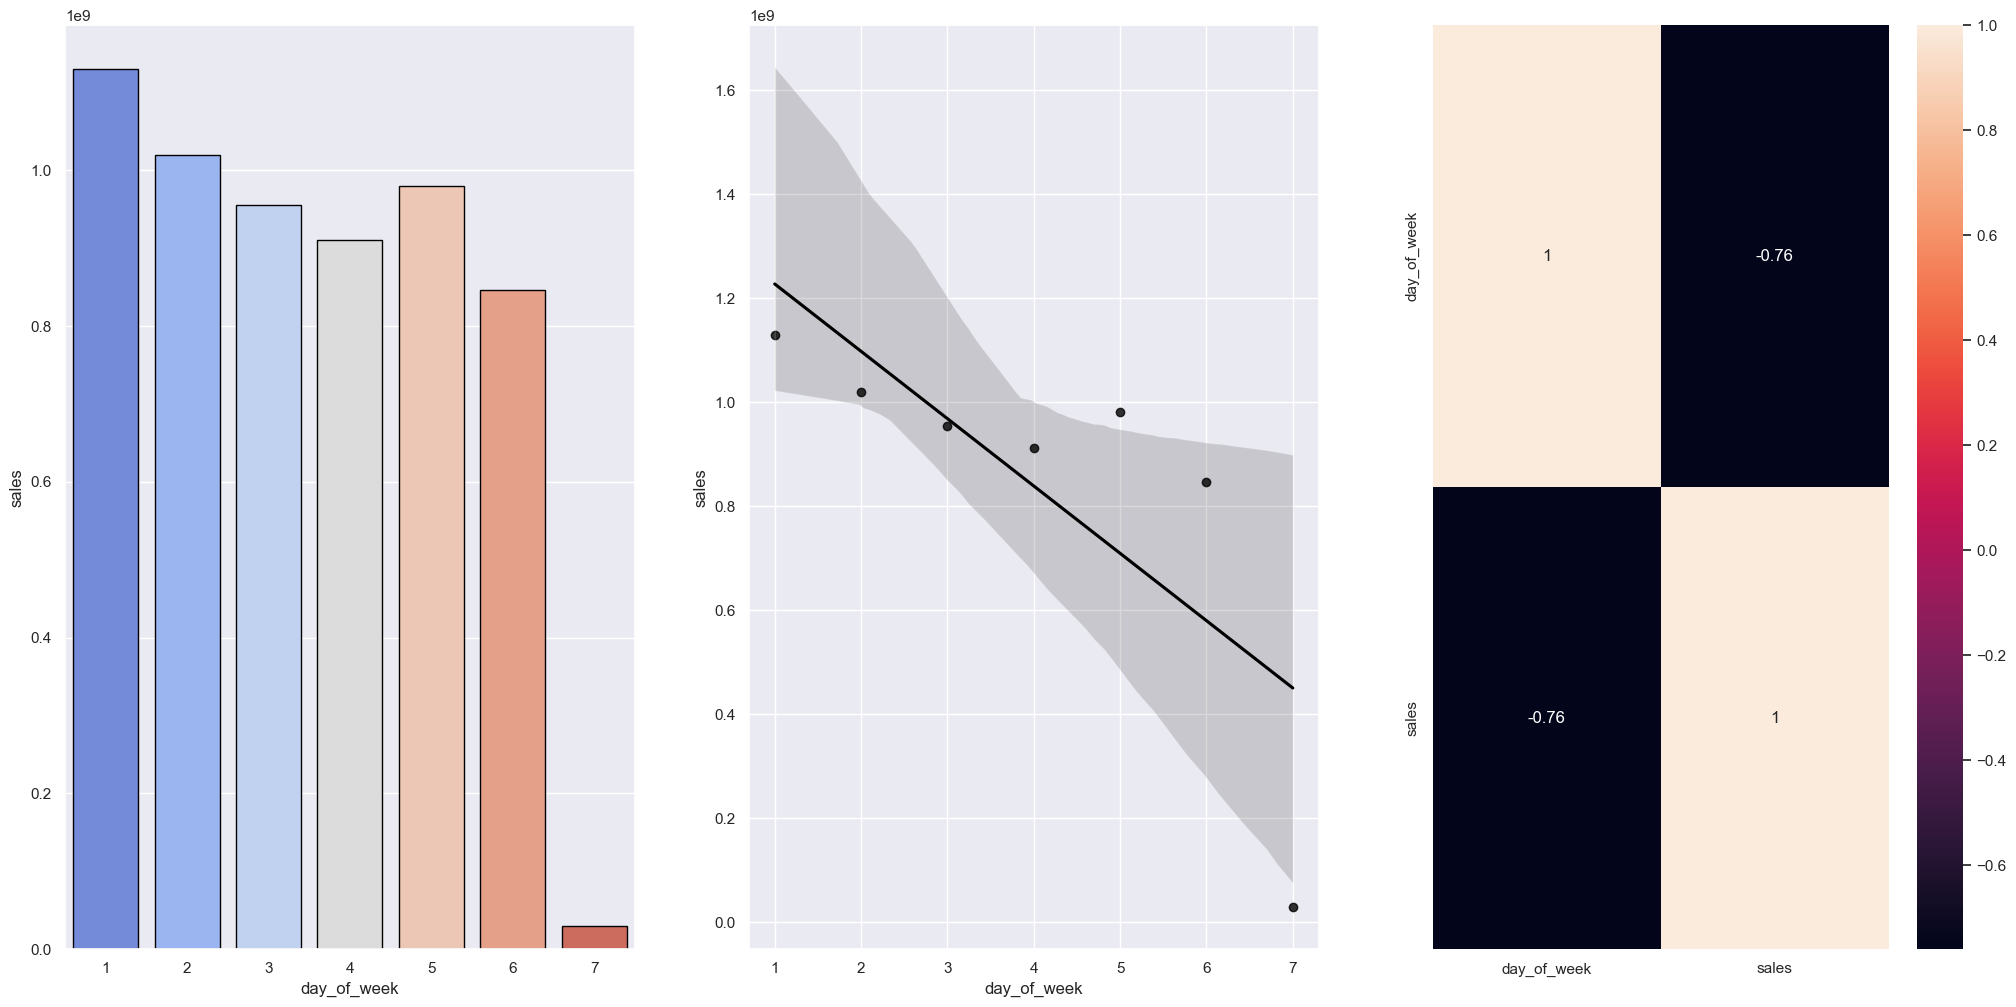

In [36]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x= 'day_of_week', y= 'sales', data=aux1, palette = 'coolwarm', alpha = 1, edgecolor= 'black')

plt.subplot(1, 3, 2)
sns.regplot(x= 'day_of_week', y= 'sales', data=aux1, color= 'black')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### **H12.** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, **exceto nos meses de julho e agosto**

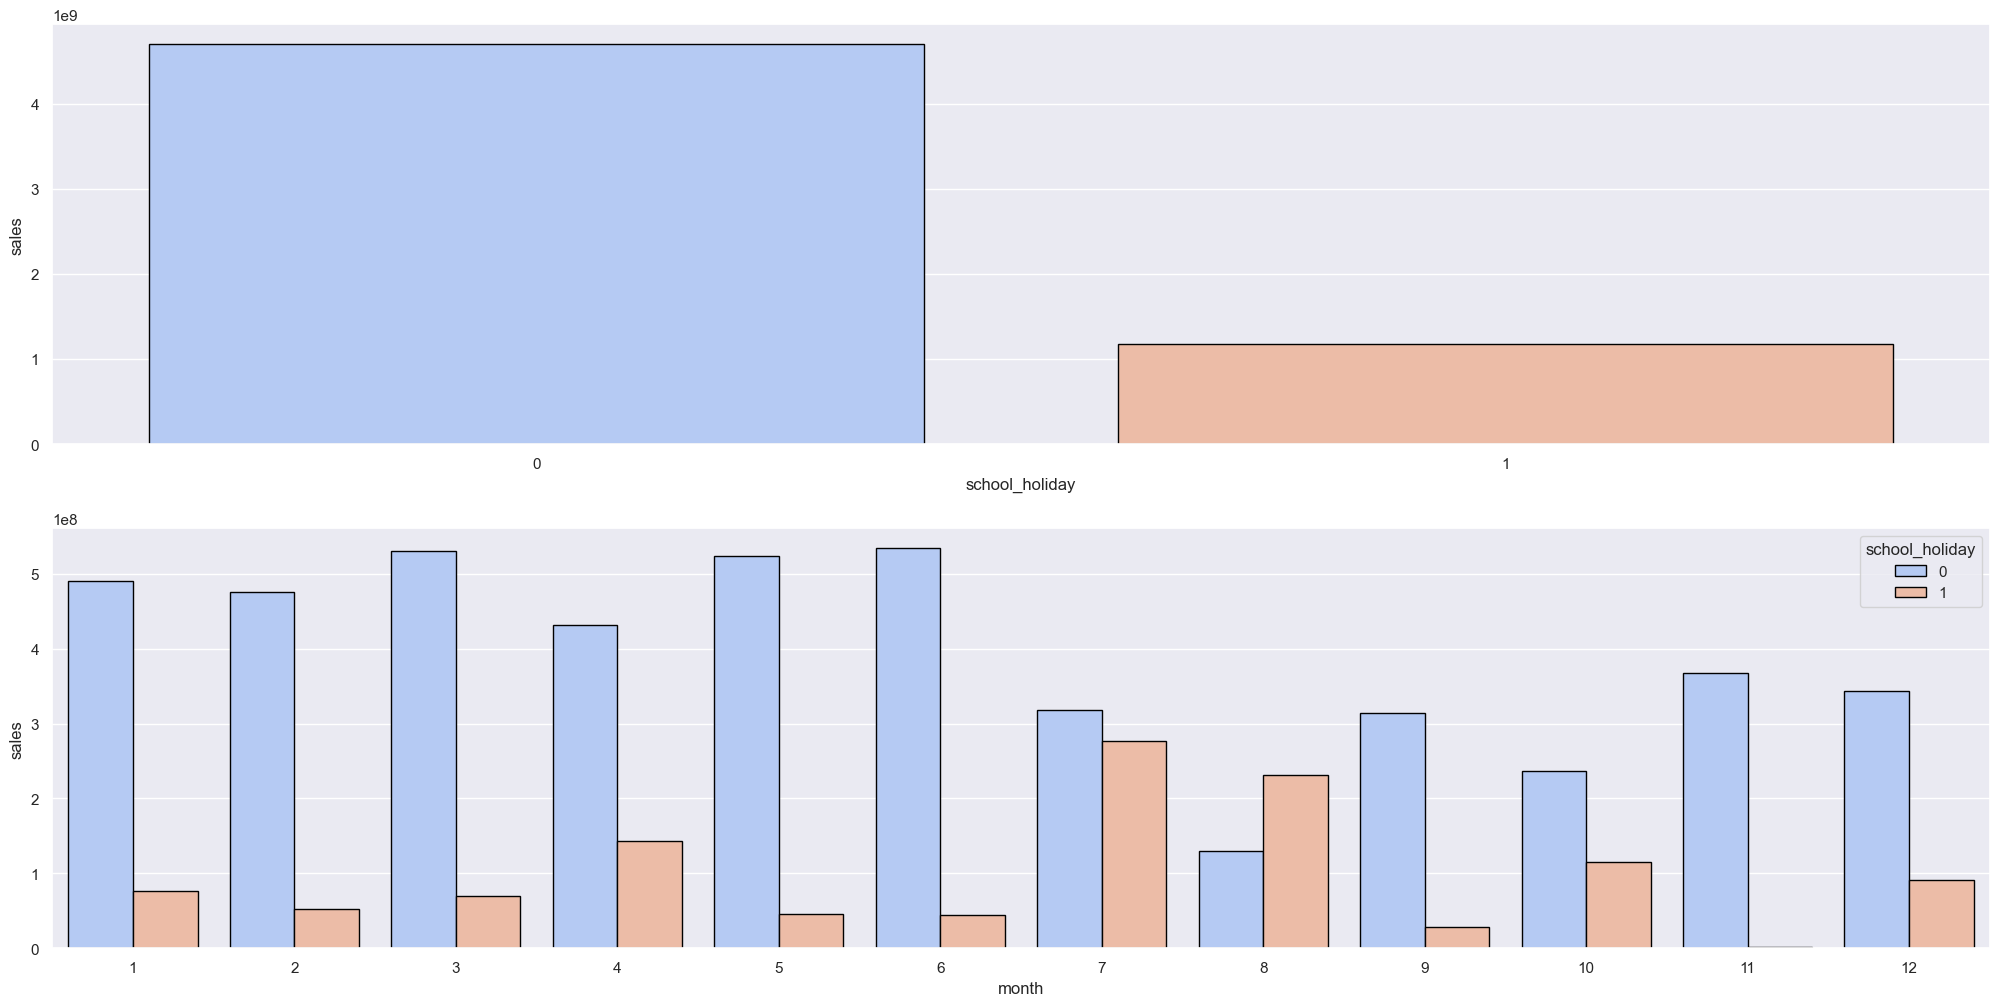

In [37]:
aux1= df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1,palette = 'coolwarm', alpha = 1, edgecolor= 'black');

aux2= df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales',hue='school_holiday',data=aux2,palette = 'coolwarm', alpha = 1, edgecolor= 'black');

### 4.2.1 SUMMARY HYPOTHESES

In [38]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
     ['H1', 'Falsa', 'Baixa'],
     ['H2', 'Falsa', 'Media'],
     ['H3', 'Falsa', 'Media'],
     ['H4', 'Falsa', 'Baixa'],
     ['H5', '-', '-'],
     ['H6', 'Falsa', 'Baixa'],
     ['H7', 'Falsa', 'Media'],
     ['H6', 'Falsa', 'Alta'],
     ['H9', 'Verdadeira', 'Alta'],
     ['H10', 'Verdadeira', 'Alta'],
     ['H11', 'Verdadeira', 'Alta'],
     ['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H6           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3. MULTIVARIATE ANALYSIS

### 4.3.1. NMERICAL ATTRIBUTES

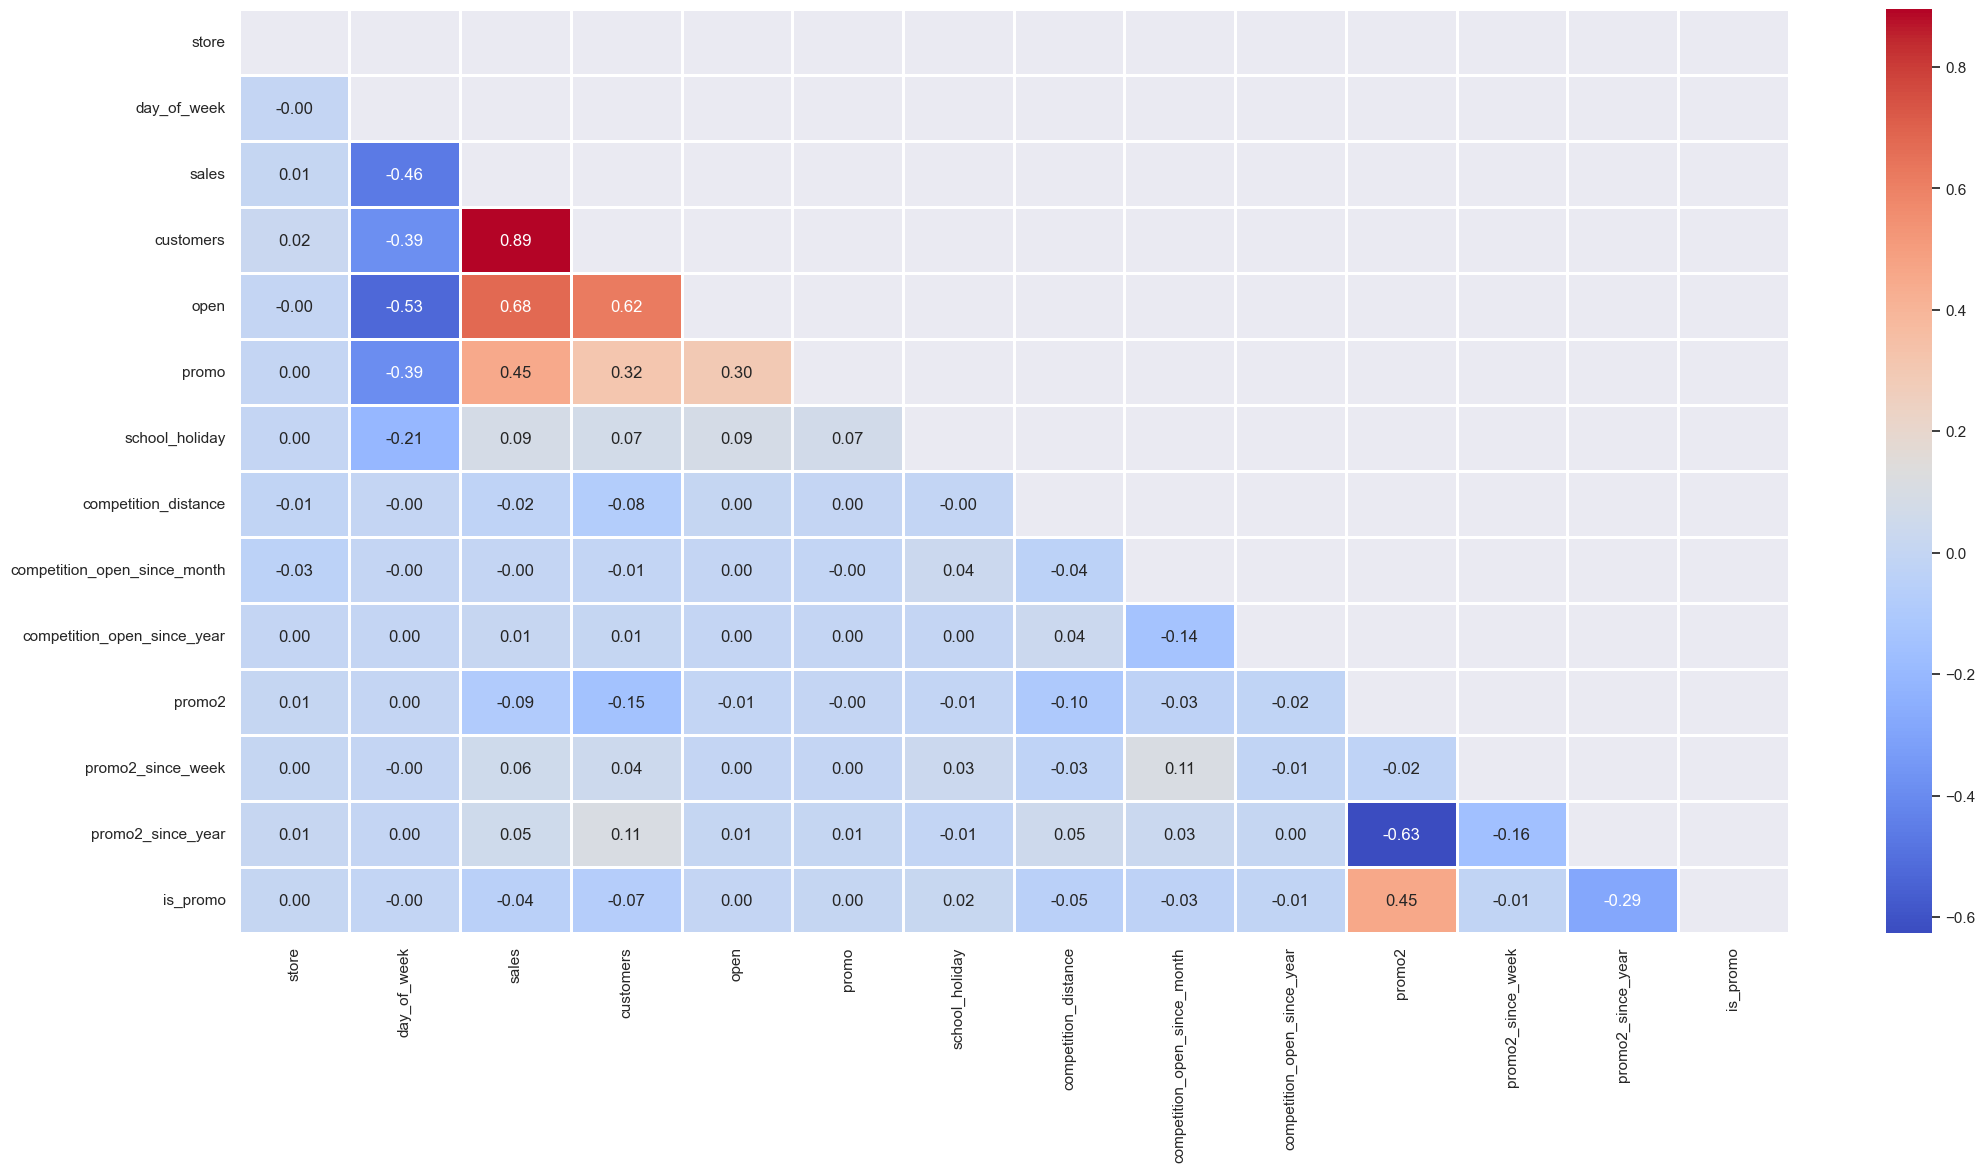

In [39]:
correlation = num_attributes.corr(method='pearson')
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix, cmap='coolwarm', linewidths=1,fmt='.2f');

### 4.3.2. CATEGORICAL ATTRIBUTES

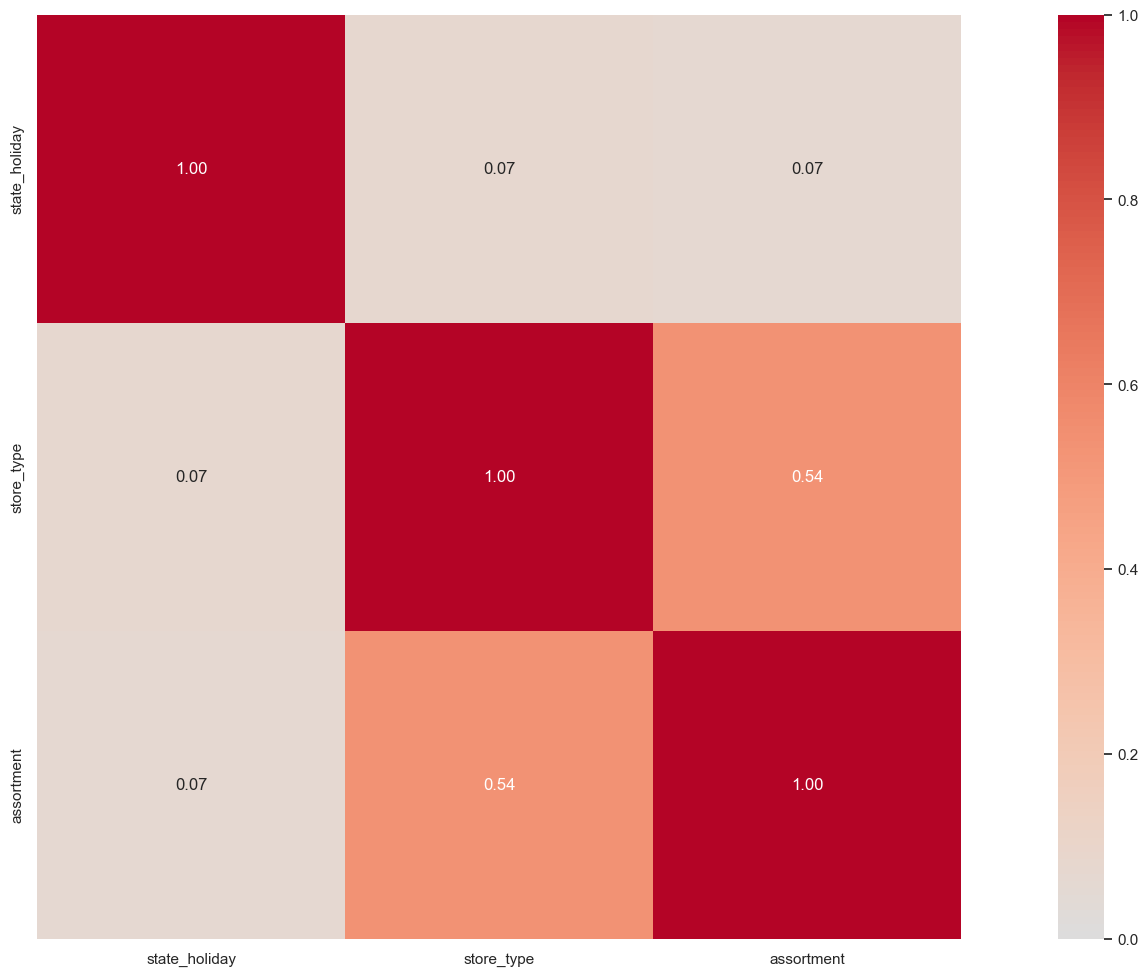

In [40]:
# Only categorical data
a = df4.select_dtypes(include='object').drop(columns='year_week')

#  FUCTION - Calculate CRAMER V with bias correction and plot categorical attributes
associations(a, cmap='coolwarm');

# 5.0. STEP 05 - DATA PREPARATION

In [41]:
df5 = df4.copy()

## 5.1.NORMALIZATION
**NON-VARIABLES WITH NORMAL DISTRIBUTION**

## 5.2. RESCALING

In [42]:
a = df5.select_dtypes(include=['int64', 'float64'])

In [43]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. TRANSFORMATION

### 5.3.1. ENCONDING

In [44]:
# state_holiday (One Hot Enconding)
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type (Label Encoding)
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment (Ordinal Encoding)
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. RESPONSE VARIABLE TRANSFORMATION

In [45]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. NATURE TRANSFORMATION

In [46]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))


# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))


# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


In [47]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. FEATURE SELECTION

In [72]:
df6 = df5.copy()

## 6.1. SPLIT DATAFRAME INTO TRAINING AND TEST DATASET

In [73]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1)

In [74]:
# Training DataSet
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# Test DataSet
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print(f"Training Min Date: {x_train['date'].min()}")
print(f"Training Max Date: {x_train['date'].max()}")

print(f"\nTest Min Date: {x_test['date'].min()}")
print(f"Test Max Date: {x_test['date'].max()}")


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. BORUTA AS FEATURE SELECTOR

In [66]:
# # training and test dataset for Boruta
# x_train_n = x_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()


# # define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # define boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose= 2, random_state=42).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
I

### 6.2.1 BEST FEATURES FROM BORUTA

In [80]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = x_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.3 MANUAL FEATURE SELECTION

In [81]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta.extend(feat_to_add)

In [83]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']